# Dual CapsNet GAN (DCN-GAN)

Jupyter notebook workspace for my ongoing thesis, please expect changes and edits. As it stands currently the GAN works well but can sometimes fail. The next step is to implement better loss functions such as Wasserstein loss to improve performance.

In [4]:
from __future__ import print_function, division
import os
import sys

import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
from keras import callbacks
from keras.utils import multi_gpu_model, to_categorical
from keras.layers.normalization import BatchNormalization
#from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask
from keras import initializers, layers, models, optimizers
from keras.backend.tensorflow_backend import set_session
from keras.datasets import mnist 
from keras.layers import Lambda, Conv2D, Activation, Embedding, Multiply
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, UpSampling1D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import LeakyReLU


K.set_image_data_format('channels_last')
#print(K.get_session().list_devices())

#os.environ["CUDA_VISIBLE_DEVICES"]="1"
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
#config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
#sess = tf.Session(config=config)
#set_session(sess) 

Using TensorFlow backend.


## Initialize classes to help build the CapsNet

In [5]:
class Length(layers.Layer):
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

class Mask(layers.Layer):
    def call(self, inputs, **kwargs):
        if type(inputs) is list:
            assert len(inputs) == 2
            inputs, mask = inputs
        else:
            x = K.sqrt(K.sum(K.square(inputs), -1))
            mask = K.one_hot(indices=K.argmax(x, 1), num_classes=x.get_shape().as_list()[1])
        masked = K.batch_flatten(inputs * K.expand_dims(mask, -1))
        return masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][1] * input_shape[0][2]])
        else:  # no true label provided
            return tuple([None, input_shape[1] * input_shape[2]])


def squash(vectors, axis=-1):
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors

In [8]:
def margin_loss(y_true, y_pred):
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))
    return K.mean(K.sum(L, 1))

In [7]:
def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
    output = layers.Conv2D(filters=dim_capsule*n_channels, kernel_size=kernel_size, strides=strides, padding=padding,
                           name='primarycap_conv2d')(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_capsule], name='primarycap_reshape')(output)
    return layers.Lambda(squash, name='primarycap_squash')(outputs)

## Create the Capsule (Digitcaps) Layer class

In [6]:
class CapsuleLayer(layers.Layer):
    def __init__(self, num_capsule, dim_capsule, num_routing=3,
                 kernel_initializer='glorot_uniform',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.num_routing = num_routing
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(shape=[self.num_capsule, self.input_num_capsule,
                                        self.dim_capsule, self.input_dim_capsule],
                                 initializer=self.kernel_initializer,
                                 name='W')
        self.built = True

    def call(self, inputs, training=None):
        inputs_expand = K.expand_dims(inputs, 1)
        inputs_tiled = K.tile(inputs_expand, [1, self.num_capsule, 1, 1])
        inputs_hat = K.map_fn(lambda x: K.batch_dot(x, self.W, [2, 3]), elems=inputs_tiled)

        # Routing-by-agreement algorithm 
        inputs_hat_stopped = K.stop_gradient(inputs_hat)
        b = tf.zeros(shape=[K.shape(inputs_hat)[0], self.num_capsule, self.input_num_capsule])
        assert self.num_routing > 0, 'The num_routing should be > 0.'
        for i in range(self.num_routing):
            c = tf.nn.softmax(b, axis=1)
            if i == self.num_routing - 1:
                outputs = squash(K.batch_dot(c, inputs_hat, [2, 2]))
            else: 
                outputs = squash(K.batch_dot(c, inputs_hat_stopped, [2, 2]))
                b += K.batch_dot(outputs, inputs_hat_stopped, [2, 3])
        return outputs

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])
    
    def get_config(self): # Overload method to fix CapsNet model saving
        """overloading this allows us to actually save this model"""
        config = {'num_capsule': self.num_capsule,
        'dim_capsule': self.dim_capsule,
        'num_routing': self.num_routing,
        'kernel_initializer': self.kernel_initializer}
        base_config = super(CapsuleLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

### Load in MNIST data with the option to also load CIFAR-10 data set as well

In [9]:
def load_dataset(dataset, width, height, channels):
    if dataset == 'mnist':
        (X_train, y_train), (X_test, y_test) = mnist.load_data()
        # rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        
    if dataset == 'cifar10':
        (X_train, y_train), (X_test, y_test) = cifar10.load_data()
        # rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5

    img_rows = width
    img_cols = height
    channels = channels
    img_shape = [img_rows, img_cols, channels]
    return X_train, img_shape  

dataset, shape = load_dataset('mnist', 28, 28, 1)
print('Dataset shape: {0}, Image shape: {1}'.format(dataset.shape, shape))

Dataset shape: (60000, 28, 28, 1), Image shape: [28, 28, 1]


### Build CapsNet Discriminator

In [10]:
def build_discriminator():
    n_class = 11
    num_routing = 3
    inn = layers.Input(shape=(shape[0], shape[1], shape[2]))

    x = Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', name='conv1')(inn)
    x = LeakyReLU()(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(filters=8 * 32, kernel_size=9, strides=2, padding='valid', name='primarycap_conv2')(x)
    x = Reshape(target_shape=[-1, 8], name='primarycap_reshape')(x)

    x = Lambda(squash, name='primarycap_squash')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Flatten()(x)

    uhat = Dense(160, kernel_initializer='he_normal', bias_initializer='zeros', name='uhat_digitcaps')(x)
    c = Activation('softmax', name='softmax_digitcaps1')(uhat)

    # s_j (output of the current capsule level) = uhat * c
    c = Dense(160)(c) # compute s_j
    x = Multiply()([uhat, c])
    s_j = LeakyReLU()(x)

    c = Activation('softmax', name='softmax_digitcaps2')(s_j)
    c = Dense(160)(c)
    x = Multiply()([uhat, c])
    s_j = LeakyReLU()(x)

    c = Activation('softmax', name='softmax_digitcaps3')(s_j) 
    c = Dense(160)(c)
    x = Multiply()([uhat, c])
    s_j = LeakyReLU()(x)

    pred = Dense(1, activation='sigmoid')(s_j)
    train_model = Model(inn, pred)
    return train_model
# build and compile the discriminator
discriminator = build_discriminator()
print('DISCRIMINATOR:')
discriminator.summary()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

DISCRIMINATOR:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 20, 20, 256)  20992       input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 20, 20, 256)  0           conv1[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 20, 20, 256)  1024        leaky_re_lu_1[0][0]              
______________________________________________________________________________________________

### Build the CapsNet Generator using the CapsuleLayer class

In [12]:
def build_generator():
    n_class = 10
    num_routing = 3

    inn = Input(shape=(100,))
    re = Reshape((10, 10))(inn)
    digit = CapsuleLayer(num_capsule=n_class, dim_capsule=588, num_routing=num_routing, 
                             name='digitcaps')(re)
    re2 = Reshape((7, 7, 120))(digit)
    up1 = UpSampling2D()(re2)
    cv1 = Conv2D(128, kernel_size=(4,4), padding="same")(up1)
    bn1 = BatchNormalization(momentum=0.8)(cv1)
    act1 = Activation("relu")(bn1)
    up2 = UpSampling2D()(act1)
    cv2 = Conv2D(64, kernel_size=(4,4), padding="same")(up2)
    bn2 = BatchNormalization(momentum=0.8)(cv2)
    act2 = Activation("relu")(bn2)
    cv3 = Conv2D(1, kernel_size=4, padding="same")(act2)
    out = Activation("tanh")(cv3)
    
    model = models.Model(inn, out)
    return model

# build and compile the generator
generator = build_generator()
print('GENERATOR:')
generator.summary()
generator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

GENERATOR:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 10, 10)            0         
_________________________________________________________________
digitcaps (CapsuleLayer)     (None, 10, 588)           588000    
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 120)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 120)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       245888    
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 128)       512       

### Combine our Discriminator and Generator models

In [13]:
# feeding noise to generator
z = Input(shape=(100,))
img = generator(z)

discriminator.trainable = False

# try to discriminate generated images
valid = discriminator(img)

# the combined model (stacked generator and discriminator) takes
# noise as input => generates images => determines validity 
combined = Model(z, valid)
print('COMBINED:')
combined.summary()
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

COMBINED:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         966817    
_________________________________________________________________
model_1 (Model)              (None, 1)                 6882881   
Total params: 7,849,698
Trainable params: 966,433
Non-trainable params: 6,883,265
_________________________________________________________________


### Define our simple train function

In [18]:
# loss values for further plotting
D_L_REAL = []
D_L_FAKE = []
D_L = []
D_ACC = []
G_L = []
def train(dataset_title, epochs, batch_size=128, save_interval=100):

    half_batch = int(batch_size / 2)

    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, dataset.shape[0], half_batch)
        imgs = dataset[idx]

        noise = np.random.normal(0, 1, (half_batch, 100))

        # generate a half batch of new images
        gen_imgs = generator.predict(noise)

        # train the discriminator by feeding both real and fake (generated) images one by one
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1))*0.9) # 0.9 for label smoothing
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        # the generator wants the discriminator to label the generated samples
        # as valid (ones)
        valid_y = np.array([1] * 32)
        # train the generator
        g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

        # Plot the progress
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
        D_L_REAL.append(d_loss_real)
        D_L_FAKE.append(d_loss_fake)
        D_L.append(d_loss)
        D_ACC.append(d_loss[1])
        G_L.append(g_loss)

        # if at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(dataset_title, epoch)

### Function for saving generated image samples

In [19]:
def save_imgs(dataset_title, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = generator.predict(noise)
        pl = './Image_MNIST_Sample'
        if not os.path.exists(pl):
            os.makedirs(pl)
        # rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        
        # iterate in order to create a subplot
        for i in range(r):
            for j in range(c):
                if dataset_title == 'mnist':
                    axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                    axs[i,j].axis('off')
                    cnt += 1
                elif dataset_title == 'cifar10':
                    axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                    axs[i,j].axis('off')
                    cnt += 1
                else:
                    print('Please indicate the image options.')
        
        if not os.path.exists('images_{0}'.format(dataset_title)):
            os.makedirs('images_{0}'.format(dataset_title))
        
        fig.savefig(pl+"/{1}.png".format(dataset_title, epoch))
        plt.close()

### Train our GAN

In [20]:
history = train('mnist', epochs=10001, batch_size=128, save_interval=100)

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.692794, acc.: 0.00%] [G loss: 0.690180]
1 [D loss: 0.697728, acc.: 10.94%] [G loss: 0.659450]
2 [D loss: 0.693920, acc.: 5.47%] [G loss: 0.659639]
3 [D loss: 0.679855, acc.: 7.81%] [G loss: 0.667162]
4 [D loss: 0.707433, acc.: 6.25%] [G loss: 0.655617]
5 [D loss: 0.717143, acc.: 2.34%] [G loss: 0.640746]
6 [D loss: 0.712456, acc.: 1.56%] [G loss: 0.655066]
7 [D loss: 0.697356, acc.: 0.00%] [G loss: 0.677342]
8 [D loss: 0.694307, acc.: 5.47%] [G loss: 0.688298]
9 [D loss: 0.694699, acc.: 10.94%] [G loss: 0.699646]
10 [D loss: 0.695057, acc.: 22.66%] [G loss: 0.709045]
11 [D loss: 0.692264, acc.: 28.91%] [G loss: 0.728633]
12 [D loss: 0.687392, acc.: 39.84%] [G loss: 0.739854]
13 [D loss: 0.677959, acc.: 42.97%] [G loss: 0.760649]
14 [D loss: 0.669285, acc.: 42.19%] [G loss: 0.769868]
15 [D loss: 0.678512, acc.: 34.38%] [G loss: 0.766680]
16 [D loss: 0.645884, acc.: 39.06%] [G loss: 0.777316]
17 [D loss: 0.661749, acc.: 29.69%] [G loss: 0.733690]
18 [D loss: 0.653354, acc.: 

149 [D loss: 0.488960, acc.: 42.97%] [G loss: 1.323665]
150 [D loss: 0.497266, acc.: 49.22%] [G loss: 1.316173]
151 [D loss: 0.494235, acc.: 45.31%] [G loss: 1.109004]
152 [D loss: 0.506280, acc.: 45.31%] [G loss: 1.077312]
153 [D loss: 0.448609, acc.: 45.31%] [G loss: 1.070071]
154 [D loss: 0.561617, acc.: 40.62%] [G loss: 0.989561]
155 [D loss: 0.504607, acc.: 42.19%] [G loss: 0.981430]
156 [D loss: 0.516727, acc.: 39.06%] [G loss: 0.931311]
157 [D loss: 0.587643, acc.: 34.38%] [G loss: 0.691970]
158 [D loss: 0.603455, acc.: 32.81%] [G loss: 0.793568]
159 [D loss: 0.655745, acc.: 32.81%] [G loss: 0.689003]
160 [D loss: 0.607067, acc.: 30.47%] [G loss: 0.713192]
161 [D loss: 0.677972, acc.: 26.56%] [G loss: 0.731671]
162 [D loss: 0.747547, acc.: 21.09%] [G loss: 0.766090]
163 [D loss: 0.727517, acc.: 21.09%] [G loss: 0.872134]
164 [D loss: 0.749448, acc.: 21.09%] [G loss: 0.981085]
165 [D loss: 0.651708, acc.: 33.59%] [G loss: 1.192092]
166 [D loss: 0.608012, acc.: 35.16%] [G loss: 1.

296 [D loss: 0.683239, acc.: 39.06%] [G loss: 1.050264]
297 [D loss: 0.678324, acc.: 39.84%] [G loss: 1.039995]
298 [D loss: 0.623901, acc.: 39.84%] [G loss: 1.022296]
299 [D loss: 0.642131, acc.: 41.41%] [G loss: 1.067810]
300 [D loss: 0.680752, acc.: 39.06%] [G loss: 1.105147]
301 [D loss: 0.633682, acc.: 43.75%] [G loss: 1.077025]
302 [D loss: 0.691299, acc.: 39.84%] [G loss: 1.115200]
303 [D loss: 0.609462, acc.: 45.31%] [G loss: 1.060846]
304 [D loss: 0.604885, acc.: 42.19%] [G loss: 1.160495]
305 [D loss: 0.631384, acc.: 33.59%] [G loss: 1.216681]
306 [D loss: 0.661317, acc.: 44.53%] [G loss: 1.156413]
307 [D loss: 0.665029, acc.: 35.94%] [G loss: 1.083503]
308 [D loss: 0.634705, acc.: 42.19%] [G loss: 1.073978]
309 [D loss: 0.653830, acc.: 35.94%] [G loss: 1.122056]
310 [D loss: 0.642288, acc.: 41.41%] [G loss: 1.077778]
311 [D loss: 0.621833, acc.: 45.31%] [G loss: 1.079960]
312 [D loss: 0.677956, acc.: 35.94%] [G loss: 1.063410]
313 [D loss: 0.639732, acc.: 32.03%] [G loss: 1.

443 [D loss: 0.549949, acc.: 42.97%] [G loss: 1.403918]
444 [D loss: 0.564814, acc.: 46.09%] [G loss: 1.356156]
445 [D loss: 0.590198, acc.: 43.75%] [G loss: 1.242702]
446 [D loss: 0.579005, acc.: 41.41%] [G loss: 1.295371]
447 [D loss: 0.688539, acc.: 38.28%] [G loss: 1.209790]
448 [D loss: 0.634018, acc.: 39.84%] [G loss: 1.196658]
449 [D loss: 0.638415, acc.: 40.62%] [G loss: 1.100580]
450 [D loss: 0.586081, acc.: 38.28%] [G loss: 1.276567]
451 [D loss: 0.608123, acc.: 39.84%] [G loss: 1.272949]
452 [D loss: 0.681313, acc.: 40.62%] [G loss: 1.210644]
453 [D loss: 0.608240, acc.: 37.50%] [G loss: 1.256517]
454 [D loss: 0.551387, acc.: 39.84%] [G loss: 1.231813]
455 [D loss: 0.603371, acc.: 39.06%] [G loss: 1.172468]
456 [D loss: 0.643891, acc.: 39.06%] [G loss: 1.090629]
457 [D loss: 0.617790, acc.: 36.72%] [G loss: 1.160374]
458 [D loss: 0.621029, acc.: 41.41%] [G loss: 1.289846]
459 [D loss: 0.568678, acc.: 43.75%] [G loss: 1.293568]
460 [D loss: 0.597332, acc.: 42.19%] [G loss: 1.

590 [D loss: 0.602888, acc.: 39.06%] [G loss: 1.307021]
591 [D loss: 0.544267, acc.: 41.41%] [G loss: 1.352818]
592 [D loss: 0.583103, acc.: 41.41%] [G loss: 1.297669]
593 [D loss: 0.561766, acc.: 39.84%] [G loss: 1.284825]
594 [D loss: 0.604764, acc.: 44.53%] [G loss: 1.360801]
595 [D loss: 0.603550, acc.: 39.06%] [G loss: 1.285538]
596 [D loss: 0.657832, acc.: 32.03%] [G loss: 1.119877]
597 [D loss: 0.600948, acc.: 37.50%] [G loss: 1.182340]
598 [D loss: 0.577070, acc.: 42.97%] [G loss: 1.111159]
599 [D loss: 0.600732, acc.: 39.06%] [G loss: 1.198151]
600 [D loss: 0.634709, acc.: 39.06%] [G loss: 1.182084]
601 [D loss: 0.605272, acc.: 39.06%] [G loss: 1.249083]
602 [D loss: 0.575810, acc.: 42.19%] [G loss: 1.335169]
603 [D loss: 0.579337, acc.: 43.75%] [G loss: 1.202192]
604 [D loss: 0.624384, acc.: 35.94%] [G loss: 1.185777]
605 [D loss: 0.579607, acc.: 41.41%] [G loss: 1.284999]
606 [D loss: 0.592351, acc.: 38.28%] [G loss: 1.196139]
607 [D loss: 0.557207, acc.: 43.75%] [G loss: 1.

737 [D loss: 0.533290, acc.: 42.97%] [G loss: 1.310491]
738 [D loss: 0.595496, acc.: 41.41%] [G loss: 1.349666]
739 [D loss: 0.567566, acc.: 40.62%] [G loss: 1.486389]
740 [D loss: 0.637642, acc.: 37.50%] [G loss: 1.264465]
741 [D loss: 0.528499, acc.: 46.09%] [G loss: 1.342617]
742 [D loss: 0.581377, acc.: 41.41%] [G loss: 1.263179]
743 [D loss: 0.580172, acc.: 39.84%] [G loss: 1.282524]
744 [D loss: 0.581787, acc.: 42.19%] [G loss: 1.332300]
745 [D loss: 0.618143, acc.: 39.06%] [G loss: 1.333676]
746 [D loss: 0.609540, acc.: 39.84%] [G loss: 1.281316]
747 [D loss: 0.584538, acc.: 37.50%] [G loss: 1.565642]
748 [D loss: 0.546223, acc.: 43.75%] [G loss: 1.461513]
749 [D loss: 0.507815, acc.: 46.88%] [G loss: 1.341326]
750 [D loss: 0.599938, acc.: 40.62%] [G loss: 1.360112]
751 [D loss: 0.592632, acc.: 36.72%] [G loss: 1.452168]
752 [D loss: 0.589314, acc.: 44.53%] [G loss: 1.374400]
753 [D loss: 0.533067, acc.: 41.41%] [G loss: 1.381257]
754 [D loss: 0.628350, acc.: 32.81%] [G loss: 1.

884 [D loss: 0.512609, acc.: 42.19%] [G loss: 1.503088]
885 [D loss: 0.575618, acc.: 39.06%] [G loss: 1.413383]
886 [D loss: 0.517204, acc.: 45.31%] [G loss: 1.505116]
887 [D loss: 0.587578, acc.: 36.72%] [G loss: 1.330325]
888 [D loss: 0.576497, acc.: 37.50%] [G loss: 1.569866]
889 [D loss: 0.539643, acc.: 41.41%] [G loss: 1.365642]
890 [D loss: 0.599250, acc.: 36.72%] [G loss: 1.570673]
891 [D loss: 0.562857, acc.: 39.84%] [G loss: 1.555079]
892 [D loss: 0.583289, acc.: 41.41%] [G loss: 1.710084]
893 [D loss: 0.505368, acc.: 44.53%] [G loss: 1.572822]
894 [D loss: 0.530720, acc.: 42.97%] [G loss: 1.431317]
895 [D loss: 0.542705, acc.: 39.06%] [G loss: 1.588663]
896 [D loss: 0.490154, acc.: 42.97%] [G loss: 1.788917]
897 [D loss: 0.625327, acc.: 35.94%] [G loss: 1.669221]
898 [D loss: 0.528822, acc.: 45.31%] [G loss: 1.535454]
899 [D loss: 0.578585, acc.: 41.41%] [G loss: 1.510896]
900 [D loss: 0.557648, acc.: 35.94%] [G loss: 1.634954]
901 [D loss: 0.573912, acc.: 39.06%] [G loss: 1.

1030 [D loss: 0.535940, acc.: 38.28%] [G loss: 1.625751]
1031 [D loss: 0.569204, acc.: 41.41%] [G loss: 1.628892]
1032 [D loss: 0.651049, acc.: 39.84%] [G loss: 1.750891]
1033 [D loss: 0.636207, acc.: 39.06%] [G loss: 1.413727]
1034 [D loss: 0.563271, acc.: 40.62%] [G loss: 1.437152]
1035 [D loss: 0.512753, acc.: 40.62%] [G loss: 1.644357]
1036 [D loss: 0.564893, acc.: 41.41%] [G loss: 1.463866]
1037 [D loss: 0.544372, acc.: 39.06%] [G loss: 1.582423]
1038 [D loss: 0.521791, acc.: 43.75%] [G loss: 1.428115]
1039 [D loss: 0.570230, acc.: 41.41%] [G loss: 1.525244]
1040 [D loss: 0.440478, acc.: 43.75%] [G loss: 1.875305]
1041 [D loss: 0.623593, acc.: 42.97%] [G loss: 1.740703]
1042 [D loss: 0.534253, acc.: 40.62%] [G loss: 1.687155]
1043 [D loss: 0.556616, acc.: 42.97%] [G loss: 1.595026]
1044 [D loss: 0.487389, acc.: 45.31%] [G loss: 1.681341]
1045 [D loss: 0.545006, acc.: 42.19%] [G loss: 1.526856]
1046 [D loss: 0.515350, acc.: 44.53%] [G loss: 1.558438]
1047 [D loss: 0.510966, acc.: 4

1174 [D loss: 0.543663, acc.: 44.53%] [G loss: 1.702035]
1175 [D loss: 0.521823, acc.: 36.72%] [G loss: 1.681874]
1176 [D loss: 0.539346, acc.: 37.50%] [G loss: 1.569769]
1177 [D loss: 0.490516, acc.: 43.75%] [G loss: 1.688383]
1178 [D loss: 0.604365, acc.: 41.41%] [G loss: 1.639705]
1179 [D loss: 0.689398, acc.: 32.03%] [G loss: 1.489466]
1180 [D loss: 0.505798, acc.: 41.41%] [G loss: 1.879606]
1181 [D loss: 0.575809, acc.: 42.97%] [G loss: 1.429775]
1182 [D loss: 0.620847, acc.: 39.06%] [G loss: 1.308722]
1183 [D loss: 0.624271, acc.: 33.59%] [G loss: 1.535196]
1184 [D loss: 0.571147, acc.: 36.72%] [G loss: 1.879334]
1185 [D loss: 0.628237, acc.: 40.62%] [G loss: 1.627458]
1186 [D loss: 0.583335, acc.: 39.84%] [G loss: 1.468834]
1187 [D loss: 0.590208, acc.: 36.72%] [G loss: 1.686584]
1188 [D loss: 0.489589, acc.: 41.41%] [G loss: 1.769617]
1189 [D loss: 0.595264, acc.: 42.19%] [G loss: 1.712789]
1190 [D loss: 0.536443, acc.: 41.41%] [G loss: 1.545913]
1191 [D loss: 0.522206, acc.: 3

1318 [D loss: 0.630333, acc.: 41.41%] [G loss: 1.546027]
1319 [D loss: 0.559893, acc.: 39.06%] [G loss: 1.608294]
1320 [D loss: 0.550876, acc.: 42.19%] [G loss: 1.706354]
1321 [D loss: 0.516698, acc.: 42.97%] [G loss: 1.611188]
1322 [D loss: 0.589147, acc.: 36.72%] [G loss: 1.775037]
1323 [D loss: 0.592580, acc.: 42.97%] [G loss: 1.607568]
1324 [D loss: 0.519753, acc.: 41.41%] [G loss: 1.587114]
1325 [D loss: 0.536951, acc.: 43.75%] [G loss: 1.582898]
1326 [D loss: 0.536681, acc.: 38.28%] [G loss: 1.733149]
1327 [D loss: 0.675411, acc.: 36.72%] [G loss: 1.812754]
1328 [D loss: 0.589675, acc.: 34.38%] [G loss: 1.677643]
1329 [D loss: 0.563729, acc.: 40.62%] [G loss: 1.713580]
1330 [D loss: 0.558161, acc.: 40.62%] [G loss: 1.561289]
1331 [D loss: 0.598890, acc.: 38.28%] [G loss: 1.718938]
1332 [D loss: 0.540780, acc.: 40.62%] [G loss: 1.749628]
1333 [D loss: 0.481514, acc.: 44.53%] [G loss: 1.855561]
1334 [D loss: 0.640375, acc.: 35.16%] [G loss: 1.619350]
1335 [D loss: 0.576596, acc.: 4

1462 [D loss: 0.488536, acc.: 39.06%] [G loss: 1.768613]
1463 [D loss: 0.509270, acc.: 40.62%] [G loss: 1.924111]
1464 [D loss: 0.524951, acc.: 42.97%] [G loss: 1.769439]
1465 [D loss: 0.561097, acc.: 42.97%] [G loss: 1.777889]
1466 [D loss: 0.517203, acc.: 42.19%] [G loss: 1.691147]
1467 [D loss: 0.518794, acc.: 39.84%] [G loss: 1.688775]
1468 [D loss: 0.510244, acc.: 39.06%] [G loss: 1.800454]
1469 [D loss: 0.529003, acc.: 39.84%] [G loss: 1.743629]
1470 [D loss: 0.529847, acc.: 39.84%] [G loss: 1.711831]
1471 [D loss: 0.545522, acc.: 40.62%] [G loss: 2.013196]
1472 [D loss: 0.559392, acc.: 44.53%] [G loss: 1.376185]
1473 [D loss: 0.487918, acc.: 40.62%] [G loss: 1.542923]
1474 [D loss: 0.516408, acc.: 40.62%] [G loss: 1.673981]
1475 [D loss: 0.565074, acc.: 39.06%] [G loss: 1.814489]
1476 [D loss: 0.487493, acc.: 42.97%] [G loss: 1.852165]
1477 [D loss: 0.581563, acc.: 36.72%] [G loss: 1.739895]
1478 [D loss: 0.594258, acc.: 43.75%] [G loss: 1.676665]
1479 [D loss: 0.587282, acc.: 4

1606 [D loss: 0.516656, acc.: 41.41%] [G loss: 1.844089]
1607 [D loss: 0.570360, acc.: 39.84%] [G loss: 1.772053]
1608 [D loss: 0.527012, acc.: 42.19%] [G loss: 1.773286]
1609 [D loss: 0.473301, acc.: 42.19%] [G loss: 1.782374]
1610 [D loss: 0.535738, acc.: 39.06%] [G loss: 1.832076]
1611 [D loss: 0.510884, acc.: 45.31%] [G loss: 1.660915]
1612 [D loss: 0.501946, acc.: 42.19%] [G loss: 1.471971]
1613 [D loss: 0.453956, acc.: 42.19%] [G loss: 1.668070]
1614 [D loss: 0.511691, acc.: 41.41%] [G loss: 1.830009]
1615 [D loss: 0.630853, acc.: 39.06%] [G loss: 1.609051]
1616 [D loss: 0.461827, acc.: 42.19%] [G loss: 1.827949]
1617 [D loss: 0.556545, acc.: 39.84%] [G loss: 1.769873]
1618 [D loss: 0.512848, acc.: 42.97%] [G loss: 1.893226]
1619 [D loss: 0.512114, acc.: 41.41%] [G loss: 1.724318]
1620 [D loss: 0.555083, acc.: 38.28%] [G loss: 1.903118]
1621 [D loss: 0.487520, acc.: 42.19%] [G loss: 1.754555]
1622 [D loss: 0.534138, acc.: 44.53%] [G loss: 1.935890]
1623 [D loss: 0.578426, acc.: 3

1750 [D loss: 0.527582, acc.: 41.41%] [G loss: 1.686721]
1751 [D loss: 0.556394, acc.: 39.84%] [G loss: 2.078895]
1752 [D loss: 0.449512, acc.: 43.75%] [G loss: 2.106549]
1753 [D loss: 0.498195, acc.: 43.75%] [G loss: 1.793536]
1754 [D loss: 0.571429, acc.: 40.62%] [G loss: 1.888652]
1755 [D loss: 0.452751, acc.: 46.09%] [G loss: 1.633827]
1756 [D loss: 0.484685, acc.: 43.75%] [G loss: 1.749612]
1757 [D loss: 0.545870, acc.: 40.62%] [G loss: 1.633547]
1758 [D loss: 0.466513, acc.: 42.19%] [G loss: 1.932685]
1759 [D loss: 0.514772, acc.: 41.41%] [G loss: 1.914953]
1760 [D loss: 0.506491, acc.: 41.41%] [G loss: 2.078337]
1761 [D loss: 0.509834, acc.: 41.41%] [G loss: 2.000275]
1762 [D loss: 0.523187, acc.: 42.19%] [G loss: 1.967566]
1763 [D loss: 0.544524, acc.: 39.06%] [G loss: 1.892430]
1764 [D loss: 0.456994, acc.: 47.66%] [G loss: 1.903566]
1765 [D loss: 0.621838, acc.: 35.94%] [G loss: 1.709451]
1766 [D loss: 0.498684, acc.: 40.62%] [G loss: 1.809904]
1767 [D loss: 0.591431, acc.: 3

1894 [D loss: 0.518060, acc.: 40.62%] [G loss: 1.552912]
1895 [D loss: 0.499321, acc.: 44.53%] [G loss: 1.812708]
1896 [D loss: 0.553757, acc.: 39.84%] [G loss: 1.613583]
1897 [D loss: 0.561451, acc.: 32.81%] [G loss: 1.626290]
1898 [D loss: 0.512366, acc.: 41.41%] [G loss: 1.921960]
1899 [D loss: 0.518976, acc.: 42.19%] [G loss: 1.723083]
1900 [D loss: 0.511285, acc.: 43.75%] [G loss: 1.710329]
1901 [D loss: 0.675714, acc.: 31.25%] [G loss: 1.508460]
1902 [D loss: 0.546682, acc.: 37.50%] [G loss: 1.899780]
1903 [D loss: 0.486107, acc.: 42.19%] [G loss: 1.829223]
1904 [D loss: 0.539267, acc.: 41.41%] [G loss: 1.717757]
1905 [D loss: 0.585151, acc.: 35.16%] [G loss: 1.477226]
1906 [D loss: 0.446709, acc.: 47.66%] [G loss: 1.865719]
1907 [D loss: 0.573263, acc.: 36.72%] [G loss: 1.754325]
1908 [D loss: 0.549096, acc.: 43.75%] [G loss: 1.686830]
1909 [D loss: 0.481861, acc.: 44.53%] [G loss: 1.694246]
1910 [D loss: 0.462211, acc.: 42.97%] [G loss: 1.770709]
1911 [D loss: 0.471529, acc.: 4

2038 [D loss: 0.529639, acc.: 39.06%] [G loss: 1.639166]
2039 [D loss: 0.458098, acc.: 44.53%] [G loss: 1.935097]
2040 [D loss: 0.479138, acc.: 42.19%] [G loss: 1.813044]
2041 [D loss: 0.543174, acc.: 38.28%] [G loss: 1.943105]
2042 [D loss: 0.523149, acc.: 40.62%] [G loss: 1.833663]
2043 [D loss: 0.504931, acc.: 41.41%] [G loss: 1.812678]
2044 [D loss: 0.555521, acc.: 34.38%] [G loss: 1.727707]
2045 [D loss: 0.475076, acc.: 40.62%] [G loss: 1.800426]
2046 [D loss: 0.538055, acc.: 43.75%] [G loss: 1.763678]
2047 [D loss: 0.469757, acc.: 41.41%] [G loss: 1.663380]
2048 [D loss: 0.534311, acc.: 39.84%] [G loss: 2.048551]
2049 [D loss: 0.558062, acc.: 40.62%] [G loss: 1.691180]
2050 [D loss: 0.632520, acc.: 35.16%] [G loss: 2.117551]
2051 [D loss: 0.577968, acc.: 41.41%] [G loss: 1.909901]
2052 [D loss: 0.536068, acc.: 39.06%] [G loss: 1.815116]
2053 [D loss: 0.481458, acc.: 43.75%] [G loss: 1.740879]
2054 [D loss: 0.488234, acc.: 39.06%] [G loss: 1.828770]
2055 [D loss: 0.434016, acc.: 4

2182 [D loss: 0.555116, acc.: 41.41%] [G loss: 1.990527]
2183 [D loss: 0.557911, acc.: 39.84%] [G loss: 1.739226]
2184 [D loss: 0.510599, acc.: 37.50%] [G loss: 1.941304]
2185 [D loss: 0.508656, acc.: 37.50%] [G loss: 2.025382]
2186 [D loss: 0.435957, acc.: 46.88%] [G loss: 1.821473]
2187 [D loss: 0.577534, acc.: 42.19%] [G loss: 1.725045]
2188 [D loss: 0.511888, acc.: 36.72%] [G loss: 2.152350]
2189 [D loss: 0.458841, acc.: 46.09%] [G loss: 1.853416]
2190 [D loss: 0.503634, acc.: 44.53%] [G loss: 1.988321]
2191 [D loss: 0.691058, acc.: 41.41%] [G loss: 1.671467]
2192 [D loss: 0.513786, acc.: 35.94%] [G loss: 1.812723]
2193 [D loss: 0.512072, acc.: 42.97%] [G loss: 1.735583]
2194 [D loss: 0.480147, acc.: 40.62%] [G loss: 1.894831]
2195 [D loss: 0.598957, acc.: 40.62%] [G loss: 1.866011]
2196 [D loss: 0.527245, acc.: 41.41%] [G loss: 2.008768]
2197 [D loss: 0.474916, acc.: 41.41%] [G loss: 1.728332]
2198 [D loss: 0.484036, acc.: 47.66%] [G loss: 1.726208]
2199 [D loss: 0.581278, acc.: 3

2326 [D loss: 0.447354, acc.: 42.19%] [G loss: 1.894303]
2327 [D loss: 0.545850, acc.: 38.28%] [G loss: 2.075866]
2328 [D loss: 0.500136, acc.: 44.53%] [G loss: 1.485229]
2329 [D loss: 0.448093, acc.: 41.41%] [G loss: 1.786640]
2330 [D loss: 0.469002, acc.: 43.75%] [G loss: 1.870023]
2331 [D loss: 0.431164, acc.: 46.09%] [G loss: 1.994612]
2332 [D loss: 0.435518, acc.: 44.53%] [G loss: 1.753060]
2333 [D loss: 0.459875, acc.: 44.53%] [G loss: 1.792210]
2334 [D loss: 0.629827, acc.: 32.81%] [G loss: 1.768947]
2335 [D loss: 0.477389, acc.: 43.75%] [G loss: 2.111146]
2336 [D loss: 0.553930, acc.: 45.31%] [G loss: 1.867484]
2337 [D loss: 0.485414, acc.: 40.62%] [G loss: 1.869823]
2338 [D loss: 0.471535, acc.: 39.06%] [G loss: 1.904377]
2339 [D loss: 0.431618, acc.: 48.44%] [G loss: 2.007494]
2340 [D loss: 0.515884, acc.: 41.41%] [G loss: 1.865048]
2341 [D loss: 0.522569, acc.: 40.62%] [G loss: 1.875855]
2342 [D loss: 0.468252, acc.: 44.53%] [G loss: 1.907069]
2343 [D loss: 0.485040, acc.: 4

2470 [D loss: 0.487070, acc.: 37.50%] [G loss: 2.068245]
2471 [D loss: 0.492687, acc.: 39.84%] [G loss: 1.935624]
2472 [D loss: 0.657794, acc.: 36.72%] [G loss: 1.954599]
2473 [D loss: 0.480884, acc.: 42.97%] [G loss: 1.754526]
2474 [D loss: 0.491904, acc.: 42.97%] [G loss: 1.782297]
2475 [D loss: 0.478383, acc.: 42.19%] [G loss: 1.770006]
2476 [D loss: 0.566202, acc.: 40.62%] [G loss: 1.715268]
2477 [D loss: 0.472954, acc.: 42.97%] [G loss: 2.054971]
2478 [D loss: 0.516548, acc.: 39.06%] [G loss: 1.934229]
2479 [D loss: 0.456496, acc.: 44.53%] [G loss: 1.929009]
2480 [D loss: 0.489655, acc.: 44.53%] [G loss: 1.798681]
2481 [D loss: 0.468725, acc.: 42.97%] [G loss: 1.764496]
2482 [D loss: 0.449108, acc.: 43.75%] [G loss: 1.929779]
2483 [D loss: 0.475083, acc.: 42.19%] [G loss: 1.846848]
2484 [D loss: 0.580927, acc.: 39.06%] [G loss: 1.699918]
2485 [D loss: 0.580242, acc.: 41.41%] [G loss: 1.853142]
2486 [D loss: 0.534610, acc.: 41.41%] [G loss: 1.862698]
2487 [D loss: 0.479960, acc.: 4

2614 [D loss: 0.509701, acc.: 44.53%] [G loss: 2.010394]
2615 [D loss: 0.528620, acc.: 39.84%] [G loss: 1.867699]
2616 [D loss: 0.511276, acc.: 42.19%] [G loss: 1.922703]
2617 [D loss: 0.505871, acc.: 42.97%] [G loss: 2.196659]
2618 [D loss: 0.486466, acc.: 43.75%] [G loss: 2.219034]
2619 [D loss: 0.533599, acc.: 40.62%] [G loss: 1.733584]
2620 [D loss: 0.462763, acc.: 40.62%] [G loss: 2.156347]
2621 [D loss: 0.511585, acc.: 45.31%] [G loss: 2.337575]
2622 [D loss: 0.551532, acc.: 42.19%] [G loss: 1.722545]
2623 [D loss: 0.447827, acc.: 46.88%] [G loss: 1.876173]
2624 [D loss: 0.446234, acc.: 42.97%] [G loss: 2.048194]
2625 [D loss: 0.532105, acc.: 41.41%] [G loss: 1.913820]
2626 [D loss: 0.468314, acc.: 43.75%] [G loss: 1.876627]
2627 [D loss: 0.475640, acc.: 43.75%] [G loss: 2.008470]
2628 [D loss: 0.446312, acc.: 43.75%] [G loss: 1.730987]
2629 [D loss: 0.465892, acc.: 44.53%] [G loss: 2.171260]
2630 [D loss: 0.411199, acc.: 46.09%] [G loss: 2.087711]
2631 [D loss: 0.527453, acc.: 3

2758 [D loss: 0.557868, acc.: 37.50%] [G loss: 2.183719]
2759 [D loss: 0.531380, acc.: 43.75%] [G loss: 1.848130]
2760 [D loss: 0.540876, acc.: 40.62%] [G loss: 2.215576]
2761 [D loss: 0.456065, acc.: 45.31%] [G loss: 2.168183]
2762 [D loss: 0.584336, acc.: 42.19%] [G loss: 1.880361]
2763 [D loss: 0.463026, acc.: 44.53%] [G loss: 1.707705]
2764 [D loss: 0.492107, acc.: 46.09%] [G loss: 1.673828]
2765 [D loss: 0.543786, acc.: 38.28%] [G loss: 2.149818]
2766 [D loss: 0.492162, acc.: 45.31%] [G loss: 2.041356]
2767 [D loss: 0.514416, acc.: 37.50%] [G loss: 2.154661]
2768 [D loss: 0.478516, acc.: 42.19%] [G loss: 2.186517]
2769 [D loss: 0.568190, acc.: 43.75%] [G loss: 2.061063]
2770 [D loss: 0.463524, acc.: 40.62%] [G loss: 2.190566]
2771 [D loss: 0.473044, acc.: 44.53%] [G loss: 1.908349]
2772 [D loss: 0.552952, acc.: 39.06%] [G loss: 1.755209]
2773 [D loss: 0.539193, acc.: 39.84%] [G loss: 2.137418]
2774 [D loss: 0.528965, acc.: 40.62%] [G loss: 2.238002]
2775 [D loss: 0.523145, acc.: 4

2902 [D loss: 0.440333, acc.: 42.97%] [G loss: 2.419768]
2903 [D loss: 0.480114, acc.: 43.75%] [G loss: 1.997819]
2904 [D loss: 0.538435, acc.: 38.28%] [G loss: 1.978286]
2905 [D loss: 0.581490, acc.: 38.28%] [G loss: 2.226405]
2906 [D loss: 0.434918, acc.: 46.88%] [G loss: 2.313693]
2907 [D loss: 0.590786, acc.: 40.62%] [G loss: 1.635662]
2908 [D loss: 0.518337, acc.: 39.84%] [G loss: 1.891087]
2909 [D loss: 0.469032, acc.: 44.53%] [G loss: 2.118895]
2910 [D loss: 0.434820, acc.: 44.53%] [G loss: 1.886045]
2911 [D loss: 0.553782, acc.: 36.72%] [G loss: 1.865805]
2912 [D loss: 0.480921, acc.: 40.62%] [G loss: 1.744215]
2913 [D loss: 0.440646, acc.: 42.19%] [G loss: 2.041909]
2914 [D loss: 0.598167, acc.: 38.28%] [G loss: 1.822336]
2915 [D loss: 0.503343, acc.: 41.41%] [G loss: 2.192099]
2916 [D loss: 0.471012, acc.: 42.97%] [G loss: 2.288639]
2917 [D loss: 0.498061, acc.: 41.41%] [G loss: 2.105780]
2918 [D loss: 0.510697, acc.: 44.53%] [G loss: 1.928961]
2919 [D loss: 0.569064, acc.: 3

3046 [D loss: 0.486419, acc.: 39.06%] [G loss: 2.139093]
3047 [D loss: 0.483656, acc.: 42.19%] [G loss: 1.953030]
3048 [D loss: 0.507744, acc.: 42.97%] [G loss: 1.899377]
3049 [D loss: 0.476180, acc.: 41.41%] [G loss: 1.766255]
3050 [D loss: 0.448065, acc.: 42.97%] [G loss: 2.388452]
3051 [D loss: 0.349516, acc.: 49.22%] [G loss: 2.048780]
3052 [D loss: 0.514621, acc.: 42.97%] [G loss: 1.700814]
3053 [D loss: 0.600439, acc.: 38.28%] [G loss: 2.076102]
3054 [D loss: 0.549224, acc.: 39.06%] [G loss: 2.188564]
3055 [D loss: 0.593358, acc.: 39.84%] [G loss: 2.026459]
3056 [D loss: 0.516421, acc.: 42.19%] [G loss: 2.236923]
3057 [D loss: 0.546732, acc.: 38.28%] [G loss: 1.955385]
3058 [D loss: 0.637961, acc.: 34.38%] [G loss: 2.077665]
3059 [D loss: 0.448877, acc.: 45.31%] [G loss: 2.180243]
3060 [D loss: 0.585950, acc.: 42.19%] [G loss: 1.743608]
3061 [D loss: 0.400561, acc.: 46.88%] [G loss: 2.088456]
3062 [D loss: 0.524786, acc.: 41.41%] [G loss: 1.730294]
3063 [D loss: 0.543854, acc.: 3

3190 [D loss: 0.633569, acc.: 37.50%] [G loss: 2.070541]
3191 [D loss: 0.467900, acc.: 42.97%] [G loss: 1.929172]
3192 [D loss: 0.484476, acc.: 45.31%] [G loss: 1.987692]
3193 [D loss: 0.430403, acc.: 43.75%] [G loss: 2.439782]
3194 [D loss: 0.593191, acc.: 40.62%] [G loss: 2.091027]
3195 [D loss: 0.459373, acc.: 42.97%] [G loss: 2.629962]
3196 [D loss: 0.529906, acc.: 42.19%] [G loss: 1.625637]
3197 [D loss: 0.478846, acc.: 43.75%] [G loss: 1.767024]
3198 [D loss: 0.457119, acc.: 41.41%] [G loss: 2.109940]
3199 [D loss: 0.516490, acc.: 42.19%] [G loss: 2.065012]
3200 [D loss: 0.562088, acc.: 42.19%] [G loss: 2.079525]
3201 [D loss: 0.585740, acc.: 37.50%] [G loss: 1.911411]
3202 [D loss: 0.593833, acc.: 39.84%] [G loss: 2.095977]
3203 [D loss: 0.485915, acc.: 42.97%] [G loss: 2.480889]
3204 [D loss: 0.544159, acc.: 40.62%] [G loss: 1.790552]
3205 [D loss: 0.434065, acc.: 42.97%] [G loss: 2.071769]
3206 [D loss: 0.492808, acc.: 42.19%] [G loss: 2.251747]
3207 [D loss: 0.491353, acc.: 4

3334 [D loss: 0.529979, acc.: 41.41%] [G loss: 2.060210]
3335 [D loss: 0.473205, acc.: 39.84%] [G loss: 2.145078]
3336 [D loss: 0.411582, acc.: 46.88%] [G loss: 2.561249]
3337 [D loss: 0.392637, acc.: 47.66%] [G loss: 2.030635]
3338 [D loss: 0.616023, acc.: 37.50%] [G loss: 1.893668]
3339 [D loss: 0.467405, acc.: 41.41%] [G loss: 2.394845]
3340 [D loss: 0.533774, acc.: 40.62%] [G loss: 2.511817]
3341 [D loss: 0.450887, acc.: 44.53%] [G loss: 1.972054]
3342 [D loss: 0.452732, acc.: 43.75%] [G loss: 1.946431]
3343 [D loss: 0.520726, acc.: 40.62%] [G loss: 1.950104]
3344 [D loss: 0.455355, acc.: 40.62%] [G loss: 2.302407]
3345 [D loss: 0.437287, acc.: 46.09%] [G loss: 2.137831]
3346 [D loss: 0.482792, acc.: 46.88%] [G loss: 2.260398]
3347 [D loss: 0.407539, acc.: 40.62%] [G loss: 1.964709]
3348 [D loss: 0.545739, acc.: 39.06%] [G loss: 2.298247]
3349 [D loss: 0.479498, acc.: 40.62%] [G loss: 1.995459]
3350 [D loss: 0.461184, acc.: 40.62%] [G loss: 2.069550]
3351 [D loss: 0.489457, acc.: 4

3478 [D loss: 0.437315, acc.: 41.41%] [G loss: 2.204078]
3479 [D loss: 0.550998, acc.: 40.62%] [G loss: 2.238584]
3480 [D loss: 0.412892, acc.: 46.09%] [G loss: 2.179335]
3481 [D loss: 0.471288, acc.: 41.41%] [G loss: 2.019054]
3482 [D loss: 0.418330, acc.: 45.31%] [G loss: 2.109569]
3483 [D loss: 0.482932, acc.: 43.75%] [G loss: 1.801695]
3484 [D loss: 0.518588, acc.: 39.06%] [G loss: 2.023772]
3485 [D loss: 0.496196, acc.: 42.19%] [G loss: 2.109138]
3486 [D loss: 0.442878, acc.: 44.53%] [G loss: 2.143124]
3487 [D loss: 0.524144, acc.: 40.62%] [G loss: 2.278405]
3488 [D loss: 0.450794, acc.: 41.41%] [G loss: 2.354656]
3489 [D loss: 0.468316, acc.: 44.53%] [G loss: 2.368279]
3490 [D loss: 0.666633, acc.: 39.06%] [G loss: 1.584431]
3491 [D loss: 0.583374, acc.: 30.47%] [G loss: 1.905923]
3492 [D loss: 0.463808, acc.: 41.41%] [G loss: 2.263999]
3493 [D loss: 0.618330, acc.: 39.84%] [G loss: 2.028923]
3494 [D loss: 0.474498, acc.: 39.84%] [G loss: 2.162002]
3495 [D loss: 0.441122, acc.: 4

3622 [D loss: 0.525549, acc.: 42.19%] [G loss: 1.697642]
3623 [D loss: 0.478329, acc.: 37.50%] [G loss: 1.996070]
3624 [D loss: 0.565654, acc.: 39.84%] [G loss: 2.267411]
3625 [D loss: 0.521311, acc.: 39.06%] [G loss: 2.121184]
3626 [D loss: 0.488197, acc.: 41.41%] [G loss: 2.195210]
3627 [D loss: 0.599390, acc.: 35.94%] [G loss: 2.454745]
3628 [D loss: 0.434758, acc.: 42.97%] [G loss: 2.588723]
3629 [D loss: 0.619638, acc.: 38.28%] [G loss: 2.018350]
3630 [D loss: 0.454113, acc.: 48.44%] [G loss: 2.259151]
3631 [D loss: 0.512894, acc.: 39.06%] [G loss: 1.825853]
3632 [D loss: 0.453614, acc.: 42.19%] [G loss: 2.213983]
3633 [D loss: 0.426645, acc.: 46.09%] [G loss: 2.259134]
3634 [D loss: 0.390397, acc.: 46.88%] [G loss: 2.113350]
3635 [D loss: 0.424758, acc.: 48.44%] [G loss: 2.313096]
3636 [D loss: 0.630238, acc.: 36.72%] [G loss: 2.003359]
3637 [D loss: 0.488424, acc.: 39.06%] [G loss: 2.230724]
3638 [D loss: 0.452166, acc.: 44.53%] [G loss: 2.124153]
3639 [D loss: 0.478036, acc.: 4

3766 [D loss: 0.575485, acc.: 41.41%] [G loss: 2.027002]
3767 [D loss: 0.436371, acc.: 42.19%] [G loss: 2.226372]
3768 [D loss: 0.512093, acc.: 42.19%] [G loss: 2.254092]
3769 [D loss: 0.387899, acc.: 47.66%] [G loss: 2.467859]
3770 [D loss: 0.479197, acc.: 45.31%] [G loss: 2.433951]
3771 [D loss: 0.414435, acc.: 45.31%] [G loss: 1.915613]
3772 [D loss: 0.532556, acc.: 42.19%] [G loss: 1.899911]
3773 [D loss: 0.442366, acc.: 40.62%] [G loss: 1.941356]
3774 [D loss: 0.462918, acc.: 39.84%] [G loss: 2.162476]
3775 [D loss: 0.461392, acc.: 42.97%] [G loss: 2.403506]
3776 [D loss: 0.382282, acc.: 46.09%] [G loss: 2.355874]
3777 [D loss: 0.620189, acc.: 40.62%] [G loss: 2.246492]
3778 [D loss: 0.629326, acc.: 40.62%] [G loss: 2.136837]
3779 [D loss: 0.561728, acc.: 37.50%] [G loss: 2.423441]
3780 [D loss: 0.443959, acc.: 46.09%] [G loss: 2.190154]
3781 [D loss: 0.432163, acc.: 45.31%] [G loss: 2.293775]
3782 [D loss: 0.562668, acc.: 33.59%] [G loss: 2.560968]
3783 [D loss: 0.526115, acc.: 4

3910 [D loss: 0.473439, acc.: 42.97%] [G loss: 2.402687]
3911 [D loss: 0.454777, acc.: 43.75%] [G loss: 2.371437]
3912 [D loss: 0.466910, acc.: 45.31%] [G loss: 2.173344]
3913 [D loss: 0.562388, acc.: 41.41%] [G loss: 1.800098]
3914 [D loss: 0.390702, acc.: 43.75%] [G loss: 2.532652]
3915 [D loss: 0.388029, acc.: 46.88%] [G loss: 2.401730]
3916 [D loss: 0.578932, acc.: 39.84%] [G loss: 1.891604]
3917 [D loss: 0.501489, acc.: 37.50%] [G loss: 2.132996]
3918 [D loss: 0.504524, acc.: 42.19%] [G loss: 2.076454]
3919 [D loss: 0.541912, acc.: 39.84%] [G loss: 2.268311]
3920 [D loss: 0.460212, acc.: 42.19%] [G loss: 2.147553]
3921 [D loss: 0.403965, acc.: 43.75%] [G loss: 2.365087]
3922 [D loss: 0.564332, acc.: 42.19%] [G loss: 2.186368]
3923 [D loss: 0.504708, acc.: 40.62%] [G loss: 2.346485]
3924 [D loss: 0.521833, acc.: 44.53%] [G loss: 2.419981]
3925 [D loss: 0.471664, acc.: 42.19%] [G loss: 2.010555]
3926 [D loss: 0.499964, acc.: 39.84%] [G loss: 2.166891]
3927 [D loss: 0.409100, acc.: 4

4054 [D loss: 0.489810, acc.: 36.72%] [G loss: 2.249720]
4055 [D loss: 0.493117, acc.: 42.19%] [G loss: 2.546893]
4056 [D loss: 0.493999, acc.: 44.53%] [G loss: 2.283145]
4057 [D loss: 0.516711, acc.: 42.97%] [G loss: 2.074639]
4058 [D loss: 0.503207, acc.: 39.84%] [G loss: 2.692744]
4059 [D loss: 0.450363, acc.: 41.41%] [G loss: 2.696320]
4060 [D loss: 0.504763, acc.: 43.75%] [G loss: 2.384677]
4061 [D loss: 0.497591, acc.: 40.62%] [G loss: 2.389102]
4062 [D loss: 0.414053, acc.: 46.09%] [G loss: 2.047341]
4063 [D loss: 0.504691, acc.: 39.84%] [G loss: 2.400980]
4064 [D loss: 0.527477, acc.: 39.84%] [G loss: 1.930015]
4065 [D loss: 0.543568, acc.: 41.41%] [G loss: 2.488693]
4066 [D loss: 0.440350, acc.: 42.97%] [G loss: 1.902166]
4067 [D loss: 0.506954, acc.: 39.84%] [G loss: 2.644437]
4068 [D loss: 0.455062, acc.: 46.88%] [G loss: 2.550476]
4069 [D loss: 0.410959, acc.: 44.53%] [G loss: 2.539165]
4070 [D loss: 0.622280, acc.: 37.50%] [G loss: 2.739983]
4071 [D loss: 0.374716, acc.: 4

4198 [D loss: 0.445884, acc.: 44.53%] [G loss: 2.461253]
4199 [D loss: 0.462816, acc.: 40.62%] [G loss: 2.262621]
4200 [D loss: 0.354762, acc.: 46.09%] [G loss: 2.507949]
4201 [D loss: 0.629152, acc.: 40.62%] [G loss: 2.303357]
4202 [D loss: 0.506073, acc.: 42.19%] [G loss: 2.643818]
4203 [D loss: 0.548682, acc.: 43.75%] [G loss: 1.917647]
4204 [D loss: 0.410577, acc.: 45.31%] [G loss: 1.932154]
4205 [D loss: 0.482037, acc.: 36.72%] [G loss: 2.667146]
4206 [D loss: 0.533496, acc.: 42.19%] [G loss: 2.384198]
4207 [D loss: 0.424586, acc.: 42.97%] [G loss: 2.383858]
4208 [D loss: 0.535983, acc.: 45.31%] [G loss: 2.158543]
4209 [D loss: 0.596878, acc.: 35.16%] [G loss: 2.435889]
4210 [D loss: 0.490387, acc.: 36.72%] [G loss: 2.829327]
4211 [D loss: 0.567205, acc.: 39.84%] [G loss: 2.556609]
4212 [D loss: 0.527321, acc.: 43.75%] [G loss: 2.469996]
4213 [D loss: 0.414043, acc.: 42.97%] [G loss: 2.449114]
4214 [D loss: 0.488035, acc.: 42.19%] [G loss: 2.699192]
4215 [D loss: 0.444141, acc.: 4

4342 [D loss: 0.416448, acc.: 46.09%] [G loss: 2.394091]
4343 [D loss: 0.529870, acc.: 41.41%] [G loss: 2.110262]
4344 [D loss: 0.527010, acc.: 40.62%] [G loss: 2.081126]
4345 [D loss: 0.419830, acc.: 44.53%] [G loss: 2.290766]
4346 [D loss: 0.458767, acc.: 45.31%] [G loss: 2.691336]
4347 [D loss: 0.602314, acc.: 35.94%] [G loss: 2.486119]
4348 [D loss: 0.447904, acc.: 42.97%] [G loss: 2.241990]
4349 [D loss: 0.456276, acc.: 41.41%] [G loss: 2.226974]
4350 [D loss: 0.470915, acc.: 44.53%] [G loss: 1.928501]
4351 [D loss: 0.342678, acc.: 46.09%] [G loss: 2.280869]
4352 [D loss: 0.395707, acc.: 47.66%] [G loss: 1.668280]
4353 [D loss: 0.487949, acc.: 34.38%] [G loss: 2.189978]
4354 [D loss: 0.466355, acc.: 44.53%] [G loss: 1.799314]
4355 [D loss: 0.521691, acc.: 42.97%] [G loss: 2.018624]
4356 [D loss: 0.367429, acc.: 46.09%] [G loss: 2.038762]
4357 [D loss: 0.556496, acc.: 35.16%] [G loss: 2.098082]
4358 [D loss: 0.546593, acc.: 39.84%] [G loss: 2.406899]
4359 [D loss: 0.408775, acc.: 4

4486 [D loss: 0.407159, acc.: 46.88%] [G loss: 2.261489]
4487 [D loss: 0.471194, acc.: 39.84%] [G loss: 2.166708]
4488 [D loss: 0.519427, acc.: 42.97%] [G loss: 2.123974]
4489 [D loss: 0.431117, acc.: 42.97%] [G loss: 1.927832]
4490 [D loss: 0.534089, acc.: 41.41%] [G loss: 2.161459]
4491 [D loss: 0.416399, acc.: 43.75%] [G loss: 2.003121]
4492 [D loss: 0.380963, acc.: 46.88%] [G loss: 2.347866]
4493 [D loss: 0.402196, acc.: 46.09%] [G loss: 2.293603]
4494 [D loss: 0.493894, acc.: 42.97%] [G loss: 2.648654]
4495 [D loss: 0.629776, acc.: 35.94%] [G loss: 2.681835]
4496 [D loss: 0.452065, acc.: 44.53%] [G loss: 2.194958]
4497 [D loss: 0.484122, acc.: 39.84%] [G loss: 2.433520]
4498 [D loss: 0.370161, acc.: 48.44%] [G loss: 2.339708]
4499 [D loss: 0.437902, acc.: 46.09%] [G loss: 2.141313]
4500 [D loss: 0.417526, acc.: 45.31%] [G loss: 2.042292]
4501 [D loss: 0.448082, acc.: 44.53%] [G loss: 1.490591]
4502 [D loss: 0.431623, acc.: 42.97%] [G loss: 1.991205]
4503 [D loss: 0.519097, acc.: 3

4630 [D loss: 0.475359, acc.: 44.53%] [G loss: 2.355764]
4631 [D loss: 0.395203, acc.: 46.88%] [G loss: 2.248418]
4632 [D loss: 0.418594, acc.: 43.75%] [G loss: 1.994827]
4633 [D loss: 0.609364, acc.: 35.94%] [G loss: 2.150736]
4634 [D loss: 0.436644, acc.: 44.53%] [G loss: 2.364011]
4635 [D loss: 0.436547, acc.: 43.75%] [G loss: 1.982778]
4636 [D loss: 0.488452, acc.: 44.53%] [G loss: 2.466763]
4637 [D loss: 0.444243, acc.: 46.88%] [G loss: 1.986178]
4638 [D loss: 0.480819, acc.: 38.28%] [G loss: 1.833266]
4639 [D loss: 0.447655, acc.: 40.62%] [G loss: 2.034902]
4640 [D loss: 0.501269, acc.: 44.53%] [G loss: 2.377538]
4641 [D loss: 0.395762, acc.: 42.97%] [G loss: 2.368303]
4642 [D loss: 0.414663, acc.: 46.09%] [G loss: 2.315930]
4643 [D loss: 0.461858, acc.: 44.53%] [G loss: 2.492975]
4644 [D loss: 0.559630, acc.: 38.28%] [G loss: 2.238367]
4645 [D loss: 0.442751, acc.: 44.53%] [G loss: 2.144660]
4646 [D loss: 0.468798, acc.: 41.41%] [G loss: 2.361222]
4647 [D loss: 0.361494, acc.: 4

4774 [D loss: 0.409268, acc.: 46.88%] [G loss: 2.284216]
4775 [D loss: 0.405280, acc.: 46.09%] [G loss: 2.382213]
4776 [D loss: 0.482058, acc.: 39.06%] [G loss: 2.679592]
4777 [D loss: 0.463509, acc.: 42.97%] [G loss: 2.266301]
4778 [D loss: 0.498252, acc.: 39.84%] [G loss: 2.300418]
4779 [D loss: 0.408925, acc.: 43.75%] [G loss: 2.519018]
4780 [D loss: 0.529971, acc.: 42.19%] [G loss: 2.374982]
4781 [D loss: 0.481125, acc.: 35.94%] [G loss: 2.580553]
4782 [D loss: 0.569700, acc.: 41.41%] [G loss: 2.588537]
4783 [D loss: 0.442711, acc.: 40.62%] [G loss: 1.975829]
4784 [D loss: 0.564507, acc.: 39.84%] [G loss: 2.515505]
4785 [D loss: 0.467134, acc.: 45.31%] [G loss: 2.293518]
4786 [D loss: 0.524064, acc.: 41.41%] [G loss: 2.616487]
4787 [D loss: 0.414835, acc.: 44.53%] [G loss: 2.267265]
4788 [D loss: 0.392144, acc.: 46.09%] [G loss: 2.596611]
4789 [D loss: 0.457932, acc.: 46.88%] [G loss: 2.595571]
4790 [D loss: 0.450951, acc.: 42.19%] [G loss: 2.307643]
4791 [D loss: 0.434081, acc.: 4

4918 [D loss: 0.548839, acc.: 35.94%] [G loss: 2.744298]
4919 [D loss: 0.535690, acc.: 41.41%] [G loss: 2.549345]
4920 [D loss: 0.466789, acc.: 46.88%] [G loss: 2.179234]
4921 [D loss: 0.457197, acc.: 41.41%] [G loss: 2.269485]
4922 [D loss: 0.435986, acc.: 46.09%] [G loss: 2.137022]
4923 [D loss: 0.444093, acc.: 39.06%] [G loss: 2.221441]
4924 [D loss: 0.604055, acc.: 39.06%] [G loss: 2.053672]
4925 [D loss: 0.435411, acc.: 40.62%] [G loss: 2.786667]
4926 [D loss: 0.544089, acc.: 43.75%] [G loss: 3.035955]
4927 [D loss: 0.405716, acc.: 46.88%] [G loss: 2.451496]
4928 [D loss: 0.489712, acc.: 46.88%] [G loss: 2.206893]
4929 [D loss: 0.443205, acc.: 39.84%] [G loss: 2.238964]
4930 [D loss: 0.431782, acc.: 41.41%] [G loss: 2.446110]
4931 [D loss: 0.603904, acc.: 38.28%] [G loss: 2.247797]
4932 [D loss: 0.429447, acc.: 45.31%] [G loss: 2.040238]
4933 [D loss: 0.365631, acc.: 45.31%] [G loss: 1.874333]
4934 [D loss: 0.554853, acc.: 34.38%] [G loss: 2.359613]
4935 [D loss: 0.356251, acc.: 4

5062 [D loss: 0.456454, acc.: 39.06%] [G loss: 2.609660]
5063 [D loss: 0.394279, acc.: 43.75%] [G loss: 3.077490]
5064 [D loss: 0.464316, acc.: 42.19%] [G loss: 2.419765]
5065 [D loss: 0.499870, acc.: 40.62%] [G loss: 2.507387]
5066 [D loss: 0.447048, acc.: 45.31%] [G loss: 2.492016]
5067 [D loss: 0.482115, acc.: 43.75%] [G loss: 2.212320]
5068 [D loss: 0.419262, acc.: 42.19%] [G loss: 2.392010]
5069 [D loss: 0.461915, acc.: 46.09%] [G loss: 1.953805]
5070 [D loss: 0.427705, acc.: 42.19%] [G loss: 2.522869]
5071 [D loss: 0.467653, acc.: 42.19%] [G loss: 2.726481]
5072 [D loss: 0.534788, acc.: 44.53%] [G loss: 2.356185]
5073 [D loss: 0.485412, acc.: 42.97%] [G loss: 2.466834]
5074 [D loss: 0.361859, acc.: 46.09%] [G loss: 2.015744]
5075 [D loss: 0.537600, acc.: 40.62%] [G loss: 2.443283]
5076 [D loss: 0.495008, acc.: 42.97%] [G loss: 2.389734]
5077 [D loss: 0.492538, acc.: 39.06%] [G loss: 2.192444]
5078 [D loss: 0.440131, acc.: 42.97%] [G loss: 2.537253]
5079 [D loss: 0.465000, acc.: 4

5206 [D loss: 0.433528, acc.: 42.97%] [G loss: 2.543298]
5207 [D loss: 0.503763, acc.: 42.19%] [G loss: 2.704400]
5208 [D loss: 0.498168, acc.: 44.53%] [G loss: 2.016742]
5209 [D loss: 0.531431, acc.: 38.28%] [G loss: 2.429554]
5210 [D loss: 0.457315, acc.: 41.41%] [G loss: 2.193814]
5211 [D loss: 0.352022, acc.: 49.22%] [G loss: 2.280468]
5212 [D loss: 0.492095, acc.: 42.97%] [G loss: 2.619677]
5213 [D loss: 0.521863, acc.: 43.75%] [G loss: 2.346585]
5214 [D loss: 0.471149, acc.: 42.19%] [G loss: 1.838901]
5215 [D loss: 0.455070, acc.: 39.84%] [G loss: 2.125353]
5216 [D loss: 0.470140, acc.: 41.41%] [G loss: 2.673776]
5217 [D loss: 0.429242, acc.: 44.53%] [G loss: 2.177510]
5218 [D loss: 0.384953, acc.: 45.31%] [G loss: 2.539135]
5219 [D loss: 0.650786, acc.: 37.50%] [G loss: 1.966141]
5220 [D loss: 0.469587, acc.: 37.50%] [G loss: 3.052982]
5221 [D loss: 0.557569, acc.: 41.41%] [G loss: 2.555855]
5222 [D loss: 0.502540, acc.: 42.97%] [G loss: 2.186759]
5223 [D loss: 0.402656, acc.: 4

5350 [D loss: 0.457890, acc.: 41.41%] [G loss: 2.391153]
5351 [D loss: 0.480792, acc.: 45.31%] [G loss: 2.638543]
5352 [D loss: 0.384423, acc.: 50.00%] [G loss: 2.152987]
5353 [D loss: 0.615367, acc.: 35.94%] [G loss: 2.382915]
5354 [D loss: 0.619051, acc.: 37.50%] [G loss: 2.550680]
5355 [D loss: 0.364683, acc.: 48.44%] [G loss: 2.920664]
5356 [D loss: 0.450255, acc.: 46.09%] [G loss: 2.352897]
5357 [D loss: 0.340721, acc.: 45.31%] [G loss: 2.793338]
5358 [D loss: 0.431790, acc.: 42.97%] [G loss: 2.079533]
5359 [D loss: 0.568282, acc.: 36.72%] [G loss: 2.638158]
5360 [D loss: 0.361058, acc.: 45.31%] [G loss: 2.864869]
5361 [D loss: 0.555979, acc.: 42.97%] [G loss: 2.279342]
5362 [D loss: 0.492964, acc.: 38.28%] [G loss: 2.309377]
5363 [D loss: 0.426690, acc.: 45.31%] [G loss: 2.248154]
5364 [D loss: 0.429146, acc.: 40.62%] [G loss: 1.984193]
5365 [D loss: 0.402683, acc.: 45.31%] [G loss: 2.760739]
5366 [D loss: 0.450460, acc.: 48.44%] [G loss: 2.219396]
5367 [D loss: 0.352640, acc.: 4

5494 [D loss: 0.425575, acc.: 46.09%] [G loss: 2.210458]
5495 [D loss: 0.525893, acc.: 41.41%] [G loss: 2.157975]
5496 [D loss: 0.427222, acc.: 41.41%] [G loss: 2.522302]
5497 [D loss: 0.411259, acc.: 46.88%] [G loss: 2.791692]
5498 [D loss: 0.511904, acc.: 40.62%] [G loss: 2.216607]
5499 [D loss: 0.456209, acc.: 46.09%] [G loss: 2.410539]
5500 [D loss: 0.502693, acc.: 38.28%] [G loss: 2.310342]
5501 [D loss: 0.373257, acc.: 45.31%] [G loss: 2.380905]
5502 [D loss: 0.450325, acc.: 44.53%] [G loss: 3.455132]
5503 [D loss: 0.345930, acc.: 48.44%] [G loss: 2.742948]
5504 [D loss: 0.468443, acc.: 43.75%] [G loss: 2.320472]
5505 [D loss: 0.327746, acc.: 46.88%] [G loss: 2.044690]
5506 [D loss: 0.547658, acc.: 36.72%] [G loss: 1.904599]
5507 [D loss: 0.496204, acc.: 40.62%] [G loss: 2.440672]
5508 [D loss: 0.421561, acc.: 45.31%] [G loss: 2.061857]
5509 [D loss: 0.423180, acc.: 47.66%] [G loss: 2.570385]
5510 [D loss: 0.428267, acc.: 41.41%] [G loss: 2.271992]
5511 [D loss: 0.436137, acc.: 4

5638 [D loss: 0.480517, acc.: 43.75%] [G loss: 2.253462]
5639 [D loss: 0.466705, acc.: 43.75%] [G loss: 2.614756]
5640 [D loss: 0.581994, acc.: 32.81%] [G loss: 2.661343]
5641 [D loss: 0.445225, acc.: 42.97%] [G loss: 2.797178]
5642 [D loss: 0.506003, acc.: 42.97%] [G loss: 2.492013]
5643 [D loss: 0.368829, acc.: 47.66%] [G loss: 2.663182]
5644 [D loss: 0.403994, acc.: 46.88%] [G loss: 2.665727]
5645 [D loss: 0.472782, acc.: 40.62%] [G loss: 2.591691]
5646 [D loss: 0.506286, acc.: 44.53%] [G loss: 1.862145]
5647 [D loss: 0.421897, acc.: 41.41%] [G loss: 2.224186]
5648 [D loss: 0.396982, acc.: 45.31%] [G loss: 2.433376]
5649 [D loss: 0.464604, acc.: 43.75%] [G loss: 2.262227]
5650 [D loss: 0.461610, acc.: 39.84%] [G loss: 2.907095]
5651 [D loss: 0.344568, acc.: 48.44%] [G loss: 2.267030]
5652 [D loss: 0.435776, acc.: 46.88%] [G loss: 1.965344]
5653 [D loss: 0.512202, acc.: 35.94%] [G loss: 2.295689]
5654 [D loss: 0.505051, acc.: 42.97%] [G loss: 2.235537]
5655 [D loss: 0.409560, acc.: 4

5782 [D loss: 0.492640, acc.: 41.41%] [G loss: 2.595864]
5783 [D loss: 0.529653, acc.: 37.50%] [G loss: 2.316646]
5784 [D loss: 0.467196, acc.: 41.41%] [G loss: 2.600362]
5785 [D loss: 0.372038, acc.: 44.53%] [G loss: 3.186161]
5786 [D loss: 0.631693, acc.: 39.06%] [G loss: 2.760151]
5787 [D loss: 0.407436, acc.: 46.09%] [G loss: 2.249366]
5788 [D loss: 0.397286, acc.: 44.53%] [G loss: 2.919003]
5789 [D loss: 0.453138, acc.: 42.97%] [G loss: 2.474568]
5790 [D loss: 0.454722, acc.: 41.41%] [G loss: 2.864789]
5791 [D loss: 0.409375, acc.: 47.66%] [G loss: 2.123316]
5792 [D loss: 0.463700, acc.: 41.41%] [G loss: 2.691302]
5793 [D loss: 0.520589, acc.: 42.19%] [G loss: 2.567248]
5794 [D loss: 0.379449, acc.: 41.41%] [G loss: 2.702101]
5795 [D loss: 0.526915, acc.: 41.41%] [G loss: 2.173460]
5796 [D loss: 0.485575, acc.: 42.19%] [G loss: 2.032888]
5797 [D loss: 0.419099, acc.: 42.97%] [G loss: 2.346712]
5798 [D loss: 0.400548, acc.: 45.31%] [G loss: 2.974101]
5799 [D loss: 0.357972, acc.: 5

5926 [D loss: 0.442771, acc.: 41.41%] [G loss: 2.813994]
5927 [D loss: 0.378543, acc.: 48.44%] [G loss: 2.390281]
5928 [D loss: 0.437645, acc.: 46.88%] [G loss: 1.979686]
5929 [D loss: 0.390746, acc.: 46.88%] [G loss: 2.487474]
5930 [D loss: 0.411076, acc.: 45.31%] [G loss: 2.838283]
5931 [D loss: 0.423098, acc.: 39.84%] [G loss: 3.202935]
5932 [D loss: 0.693141, acc.: 37.50%] [G loss: 2.541954]
5933 [D loss: 0.396891, acc.: 46.88%] [G loss: 3.055295]
5934 [D loss: 0.543585, acc.: 42.97%] [G loss: 2.319528]
5935 [D loss: 0.462373, acc.: 40.62%] [G loss: 2.229925]
5936 [D loss: 0.576943, acc.: 33.59%] [G loss: 2.856395]
5937 [D loss: 0.439733, acc.: 42.19%] [G loss: 2.836526]
5938 [D loss: 0.374249, acc.: 47.66%] [G loss: 2.704999]
5939 [D loss: 0.433048, acc.: 45.31%] [G loss: 2.396100]
5940 [D loss: 0.648930, acc.: 35.16%] [G loss: 2.377217]
5941 [D loss: 0.440683, acc.: 45.31%] [G loss: 3.045900]
5942 [D loss: 0.388728, acc.: 46.09%] [G loss: 2.944131]
5943 [D loss: 0.518689, acc.: 3

6070 [D loss: 0.628319, acc.: 39.84%] [G loss: 2.319412]
6071 [D loss: 0.421281, acc.: 46.09%] [G loss: 2.545020]
6072 [D loss: 0.436098, acc.: 45.31%] [G loss: 1.884154]
6073 [D loss: 0.483501, acc.: 39.84%] [G loss: 2.657247]
6074 [D loss: 0.362677, acc.: 46.88%] [G loss: 2.946661]
6075 [D loss: 0.515089, acc.: 39.84%] [G loss: 2.864436]
6076 [D loss: 0.316494, acc.: 49.22%] [G loss: 2.775597]
6077 [D loss: 0.502779, acc.: 44.53%] [G loss: 2.015984]
6078 [D loss: 0.427598, acc.: 46.09%] [G loss: 2.363310]
6079 [D loss: 0.577501, acc.: 32.03%] [G loss: 1.914030]
6080 [D loss: 0.386091, acc.: 48.44%] [G loss: 2.733057]
6081 [D loss: 0.361367, acc.: 46.09%] [G loss: 2.455767]
6082 [D loss: 0.446865, acc.: 44.53%] [G loss: 2.595913]
6083 [D loss: 0.410325, acc.: 46.09%] [G loss: 2.893751]
6084 [D loss: 0.554644, acc.: 37.50%] [G loss: 2.120213]
6085 [D loss: 0.424621, acc.: 44.53%] [G loss: 2.421740]
6086 [D loss: 0.632405, acc.: 34.38%] [G loss: 2.601809]
6087 [D loss: 0.542337, acc.: 4

6214 [D loss: 0.491244, acc.: 40.62%] [G loss: 2.258852]
6215 [D loss: 0.461469, acc.: 42.97%] [G loss: 2.085276]
6216 [D loss: 0.465777, acc.: 39.06%] [G loss: 2.531584]
6217 [D loss: 0.477101, acc.: 44.53%] [G loss: 2.546105]
6218 [D loss: 0.474745, acc.: 42.97%] [G loss: 2.026434]
6219 [D loss: 0.418579, acc.: 46.88%] [G loss: 2.397864]
6220 [D loss: 0.388101, acc.: 46.88%] [G loss: 2.837184]
6221 [D loss: 0.485391, acc.: 44.53%] [G loss: 2.236379]
6222 [D loss: 0.389360, acc.: 47.66%] [G loss: 2.209633]
6223 [D loss: 0.498532, acc.: 37.50%] [G loss: 2.672864]
6224 [D loss: 0.458890, acc.: 43.75%] [G loss: 2.351436]
6225 [D loss: 0.532159, acc.: 39.84%] [G loss: 2.128765]
6226 [D loss: 0.454997, acc.: 42.19%] [G loss: 2.457888]
6227 [D loss: 0.392669, acc.: 44.53%] [G loss: 2.256361]
6228 [D loss: 0.424578, acc.: 46.88%] [G loss: 2.462402]
6229 [D loss: 0.600992, acc.: 35.16%] [G loss: 2.092425]
6230 [D loss: 0.413337, acc.: 44.53%] [G loss: 2.260632]
6231 [D loss: 0.363018, acc.: 4

6358 [D loss: 0.537754, acc.: 39.84%] [G loss: 3.111931]
6359 [D loss: 0.432041, acc.: 45.31%] [G loss: 2.438022]
6360 [D loss: 0.608849, acc.: 42.19%] [G loss: 2.005268]
6361 [D loss: 0.487214, acc.: 39.06%] [G loss: 2.596470]
6362 [D loss: 0.396591, acc.: 43.75%] [G loss: 2.449859]
6363 [D loss: 0.453645, acc.: 44.53%] [G loss: 2.569451]
6364 [D loss: 0.525046, acc.: 42.97%] [G loss: 2.178875]
6365 [D loss: 0.457520, acc.: 39.06%] [G loss: 2.511615]
6366 [D loss: 0.447775, acc.: 42.97%] [G loss: 2.359140]
6367 [D loss: 0.408459, acc.: 48.44%] [G loss: 2.310106]
6368 [D loss: 0.466197, acc.: 42.97%] [G loss: 2.231752]
6369 [D loss: 0.501137, acc.: 35.16%] [G loss: 2.419020]
6370 [D loss: 0.438486, acc.: 48.44%] [G loss: 2.751856]
6371 [D loss: 0.359335, acc.: 47.66%] [G loss: 2.446433]
6372 [D loss: 0.510565, acc.: 42.19%] [G loss: 1.890602]
6373 [D loss: 0.521345, acc.: 39.84%] [G loss: 2.309863]
6374 [D loss: 0.432597, acc.: 45.31%] [G loss: 2.169209]
6375 [D loss: 0.390986, acc.: 4

6502 [D loss: 0.406280, acc.: 41.41%] [G loss: 2.752707]
6503 [D loss: 0.538419, acc.: 40.62%] [G loss: 2.889138]
6504 [D loss: 0.487762, acc.: 39.06%] [G loss: 2.708892]
6505 [D loss: 0.399045, acc.: 44.53%] [G loss: 2.641108]
6506 [D loss: 0.560665, acc.: 42.19%] [G loss: 2.517919]
6507 [D loss: 0.344528, acc.: 47.66%] [G loss: 2.403435]
6508 [D loss: 0.363675, acc.: 45.31%] [G loss: 2.569335]
6509 [D loss: 0.504487, acc.: 39.06%] [G loss: 2.450930]
6510 [D loss: 0.405550, acc.: 46.88%] [G loss: 2.662642]
6511 [D loss: 0.445260, acc.: 39.84%] [G loss: 2.709782]
6512 [D loss: 0.316790, acc.: 48.44%] [G loss: 3.219476]
6513 [D loss: 0.534923, acc.: 44.53%] [G loss: 2.270986]
6514 [D loss: 0.451630, acc.: 42.19%] [G loss: 2.445830]
6515 [D loss: 0.329068, acc.: 45.31%] [G loss: 2.761743]
6516 [D loss: 0.423657, acc.: 45.31%] [G loss: 2.596437]
6517 [D loss: 0.479012, acc.: 43.75%] [G loss: 2.753526]
6518 [D loss: 0.478698, acc.: 44.53%] [G loss: 2.117105]
6519 [D loss: 0.381161, acc.: 4

6646 [D loss: 0.458665, acc.: 41.41%] [G loss: 2.935090]
6647 [D loss: 0.380382, acc.: 46.09%] [G loss: 3.066257]
6648 [D loss: 0.483420, acc.: 41.41%] [G loss: 2.994730]
6649 [D loss: 0.500166, acc.: 44.53%] [G loss: 2.554576]
6650 [D loss: 0.438915, acc.: 42.97%] [G loss: 2.380651]
6651 [D loss: 0.440861, acc.: 42.97%] [G loss: 2.790450]
6652 [D loss: 0.378738, acc.: 46.88%] [G loss: 2.998949]
6653 [D loss: 0.421071, acc.: 41.41%] [G loss: 3.319238]
6654 [D loss: 0.385206, acc.: 47.66%] [G loss: 2.685699]
6655 [D loss: 0.475968, acc.: 42.19%] [G loss: 1.893808]
6656 [D loss: 0.381270, acc.: 46.09%] [G loss: 2.119374]
6657 [D loss: 0.401688, acc.: 43.75%] [G loss: 2.616421]
6658 [D loss: 0.386713, acc.: 45.31%] [G loss: 2.691315]
6659 [D loss: 0.540039, acc.: 39.06%] [G loss: 2.846078]
6660 [D loss: 0.483146, acc.: 42.97%] [G loss: 2.969392]
6661 [D loss: 0.376061, acc.: 49.22%] [G loss: 2.569890]
6662 [D loss: 0.395048, acc.: 43.75%] [G loss: 2.657740]
6663 [D loss: 0.464119, acc.: 4

6790 [D loss: 0.451102, acc.: 42.97%] [G loss: 2.682894]
6791 [D loss: 0.493898, acc.: 39.84%] [G loss: 3.111317]
6792 [D loss: 0.600396, acc.: 36.72%] [G loss: 2.918060]
6793 [D loss: 0.438235, acc.: 46.09%] [G loss: 2.650752]
6794 [D loss: 0.488233, acc.: 40.62%] [G loss: 2.696522]
6795 [D loss: 0.440740, acc.: 42.19%] [G loss: 2.482394]
6796 [D loss: 0.436805, acc.: 39.06%] [G loss: 3.332454]
6797 [D loss: 0.434047, acc.: 47.66%] [G loss: 2.541761]
6798 [D loss: 0.473312, acc.: 42.97%] [G loss: 2.537197]
6799 [D loss: 0.465959, acc.: 43.75%] [G loss: 2.733166]
6800 [D loss: 0.436737, acc.: 39.06%] [G loss: 3.151911]
6801 [D loss: 0.552938, acc.: 41.41%] [G loss: 3.327214]
6802 [D loss: 0.406057, acc.: 50.00%] [G loss: 2.179843]
6803 [D loss: 0.535831, acc.: 33.59%] [G loss: 3.183653]
6804 [D loss: 0.393560, acc.: 45.31%] [G loss: 3.571351]
6805 [D loss: 0.605940, acc.: 41.41%] [G loss: 2.313235]
6806 [D loss: 0.377158, acc.: 46.09%] [G loss: 2.336723]
6807 [D loss: 0.427090, acc.: 4

6934 [D loss: 0.390032, acc.: 43.75%] [G loss: 2.652908]
6935 [D loss: 0.482614, acc.: 42.19%] [G loss: 2.753777]
6936 [D loss: 0.407072, acc.: 46.09%] [G loss: 2.397963]
6937 [D loss: 0.461029, acc.: 46.09%] [G loss: 2.480003]
6938 [D loss: 0.394590, acc.: 42.97%] [G loss: 3.003851]
6939 [D loss: 0.432107, acc.: 42.97%] [G loss: 2.965644]
6940 [D loss: 0.518912, acc.: 44.53%] [G loss: 2.655082]
6941 [D loss: 0.610484, acc.: 34.38%] [G loss: 2.871512]
6942 [D loss: 0.322612, acc.: 49.22%] [G loss: 2.952083]
6943 [D loss: 0.462553, acc.: 46.88%] [G loss: 1.966666]
6944 [D loss: 0.448676, acc.: 42.19%] [G loss: 2.724897]
6945 [D loss: 0.497561, acc.: 39.06%] [G loss: 2.443864]
6946 [D loss: 0.389054, acc.: 44.53%] [G loss: 3.035439]
6947 [D loss: 0.317177, acc.: 46.88%] [G loss: 2.853024]
6948 [D loss: 0.478020, acc.: 41.41%] [G loss: 2.687443]
6949 [D loss: 0.527291, acc.: 42.97%] [G loss: 2.465840]
6950 [D loss: 0.479199, acc.: 42.19%] [G loss: 2.624263]
6951 [D loss: 0.420116, acc.: 4

7078 [D loss: 0.420666, acc.: 42.97%] [G loss: 2.798681]
7079 [D loss: 0.407354, acc.: 43.75%] [G loss: 2.734132]
7080 [D loss: 0.449954, acc.: 47.66%] [G loss: 2.392691]
7081 [D loss: 0.356424, acc.: 46.09%] [G loss: 2.251683]
7082 [D loss: 0.402534, acc.: 43.75%] [G loss: 2.402303]
7083 [D loss: 0.374120, acc.: 43.75%] [G loss: 2.590610]
7084 [D loss: 0.512429, acc.: 41.41%] [G loss: 2.705672]
7085 [D loss: 0.382630, acc.: 48.44%] [G loss: 2.280140]
7086 [D loss: 0.442240, acc.: 40.62%] [G loss: 2.496061]
7087 [D loss: 0.298398, acc.: 47.66%] [G loss: 2.972848]
7088 [D loss: 0.424959, acc.: 48.44%] [G loss: 2.296098]
7089 [D loss: 0.450521, acc.: 42.19%] [G loss: 2.570103]
7090 [D loss: 0.413677, acc.: 42.97%] [G loss: 3.151290]
7091 [D loss: 0.522671, acc.: 39.84%] [G loss: 2.666519]
7092 [D loss: 0.356968, acc.: 47.66%] [G loss: 2.526648]
7093 [D loss: 0.356119, acc.: 46.88%] [G loss: 2.697720]
7094 [D loss: 0.405716, acc.: 47.66%] [G loss: 2.434485]
7095 [D loss: 0.410656, acc.: 4

7222 [D loss: 0.455910, acc.: 43.75%] [G loss: 2.780372]
7223 [D loss: 0.428379, acc.: 44.53%] [G loss: 2.395710]
7224 [D loss: 0.529003, acc.: 39.84%] [G loss: 2.779371]
7225 [D loss: 0.411294, acc.: 43.75%] [G loss: 3.129333]
7226 [D loss: 0.406403, acc.: 43.75%] [G loss: 2.673064]
7227 [D loss: 0.475681, acc.: 41.41%] [G loss: 2.729407]
7228 [D loss: 0.430766, acc.: 43.75%] [G loss: 2.882629]
7229 [D loss: 0.430187, acc.: 43.75%] [G loss: 2.738356]
7230 [D loss: 0.369357, acc.: 49.22%] [G loss: 2.863792]
7231 [D loss: 0.469088, acc.: 44.53%] [G loss: 2.863220]
7232 [D loss: 0.404840, acc.: 41.41%] [G loss: 2.605970]
7233 [D loss: 0.314101, acc.: 48.44%] [G loss: 2.549878]
7234 [D loss: 0.424226, acc.: 46.09%] [G loss: 2.064693]
7235 [D loss: 0.360290, acc.: 47.66%] [G loss: 2.386220]
7236 [D loss: 0.526700, acc.: 38.28%] [G loss: 2.577718]
7237 [D loss: 0.385019, acc.: 45.31%] [G loss: 2.836997]
7238 [D loss: 0.358077, acc.: 48.44%] [G loss: 3.017215]
7239 [D loss: 0.425458, acc.: 4

7366 [D loss: 0.426041, acc.: 46.09%] [G loss: 2.200659]
7367 [D loss: 0.432521, acc.: 38.28%] [G loss: 2.448673]
7368 [D loss: 0.455177, acc.: 41.41%] [G loss: 2.696896]
7369 [D loss: 0.358494, acc.: 46.88%] [G loss: 2.959529]
7370 [D loss: 0.356717, acc.: 48.44%] [G loss: 2.319549]
7371 [D loss: 0.406929, acc.: 42.97%] [G loss: 2.509405]
7372 [D loss: 0.435897, acc.: 43.75%] [G loss: 2.800774]
7373 [D loss: 0.471662, acc.: 47.66%] [G loss: 2.562751]
7374 [D loss: 0.436502, acc.: 43.75%] [G loss: 2.484786]
7375 [D loss: 0.396551, acc.: 42.19%] [G loss: 2.706857]
7376 [D loss: 0.353543, acc.: 46.09%] [G loss: 2.232382]
7377 [D loss: 0.492262, acc.: 38.28%] [G loss: 2.479300]
7378 [D loss: 0.342980, acc.: 47.66%] [G loss: 2.911707]
7379 [D loss: 0.353907, acc.: 45.31%] [G loss: 2.605798]
7380 [D loss: 0.477123, acc.: 39.84%] [G loss: 2.850918]
7381 [D loss: 0.412537, acc.: 46.88%] [G loss: 2.491986]
7382 [D loss: 0.440707, acc.: 42.19%] [G loss: 2.567840]
7383 [D loss: 0.382363, acc.: 4

7510 [D loss: 0.348201, acc.: 48.44%] [G loss: 2.657625]
7511 [D loss: 0.563704, acc.: 39.06%] [G loss: 2.813634]
7512 [D loss: 0.523178, acc.: 38.28%] [G loss: 2.734710]
7513 [D loss: 0.465583, acc.: 40.62%] [G loss: 2.612056]
7514 [D loss: 0.386970, acc.: 45.31%] [G loss: 2.461299]
7515 [D loss: 0.438970, acc.: 42.97%] [G loss: 2.679194]
7516 [D loss: 0.405507, acc.: 46.09%] [G loss: 2.603560]
7517 [D loss: 0.365642, acc.: 46.09%] [G loss: 2.576626]
7518 [D loss: 0.395789, acc.: 44.53%] [G loss: 2.940316]
7519 [D loss: 0.469653, acc.: 42.97%] [G loss: 2.316405]
7520 [D loss: 0.379341, acc.: 47.66%] [G loss: 2.802841]
7521 [D loss: 0.444572, acc.: 41.41%] [G loss: 2.839670]
7522 [D loss: 0.389045, acc.: 46.88%] [G loss: 2.232783]
7523 [D loss: 0.452525, acc.: 39.84%] [G loss: 3.102421]
7524 [D loss: 0.333259, acc.: 48.44%] [G loss: 2.613456]
7525 [D loss: 0.452863, acc.: 45.31%] [G loss: 2.356200]
7526 [D loss: 0.524939, acc.: 36.72%] [G loss: 2.235542]
7527 [D loss: 0.385963, acc.: 4

7654 [D loss: 0.464102, acc.: 41.41%] [G loss: 2.718373]
7655 [D loss: 0.419955, acc.: 43.75%] [G loss: 2.907584]
7656 [D loss: 0.546802, acc.: 40.62%] [G loss: 2.712663]
7657 [D loss: 0.420325, acc.: 45.31%] [G loss: 2.417704]
7658 [D loss: 0.496996, acc.: 43.75%] [G loss: 2.672236]
7659 [D loss: 0.443662, acc.: 39.06%] [G loss: 2.471816]
7660 [D loss: 0.479332, acc.: 41.41%] [G loss: 2.574869]
7661 [D loss: 0.557023, acc.: 35.94%] [G loss: 2.907423]
7662 [D loss: 0.473455, acc.: 44.53%] [G loss: 2.456306]
7663 [D loss: 0.539496, acc.: 39.06%] [G loss: 2.328422]
7664 [D loss: 0.448446, acc.: 39.84%] [G loss: 2.835909]
7665 [D loss: 0.420737, acc.: 45.31%] [G loss: 2.368589]
7666 [D loss: 0.494058, acc.: 41.41%] [G loss: 2.028428]
7667 [D loss: 0.483253, acc.: 39.06%] [G loss: 2.262745]
7668 [D loss: 0.445879, acc.: 39.06%] [G loss: 3.372924]
7669 [D loss: 0.370011, acc.: 48.44%] [G loss: 2.872859]
7670 [D loss: 0.378312, acc.: 46.88%] [G loss: 2.271261]
7671 [D loss: 0.450951, acc.: 4

7798 [D loss: 0.490451, acc.: 44.53%] [G loss: 2.474026]
7799 [D loss: 0.335698, acc.: 46.88%] [G loss: 2.988637]
7800 [D loss: 0.349092, acc.: 46.09%] [G loss: 2.223783]
7801 [D loss: 0.334412, acc.: 48.44%] [G loss: 2.802886]
7802 [D loss: 0.349037, acc.: 47.66%] [G loss: 3.282223]
7803 [D loss: 0.571851, acc.: 43.75%] [G loss: 2.394988]
7804 [D loss: 0.486795, acc.: 39.84%] [G loss: 2.341897]
7805 [D loss: 0.379185, acc.: 45.31%] [G loss: 2.794751]
7806 [D loss: 0.341306, acc.: 48.44%] [G loss: 2.435215]
7807 [D loss: 0.398215, acc.: 44.53%] [G loss: 3.254163]
7808 [D loss: 0.336346, acc.: 46.09%] [G loss: 3.091431]
7809 [D loss: 0.493756, acc.: 45.31%] [G loss: 2.684095]
7810 [D loss: 0.489766, acc.: 42.19%] [G loss: 2.815504]
7811 [D loss: 0.476232, acc.: 41.41%] [G loss: 3.100495]
7812 [D loss: 0.422291, acc.: 43.75%] [G loss: 2.631930]
7813 [D loss: 0.364902, acc.: 49.22%] [G loss: 2.852408]
7814 [D loss: 0.537538, acc.: 44.53%] [G loss: 2.367785]
7815 [D loss: 0.318917, acc.: 4

7942 [D loss: 0.342566, acc.: 46.09%] [G loss: 3.210622]
7943 [D loss: 0.450635, acc.: 43.75%] [G loss: 2.269583]
7944 [D loss: 0.372190, acc.: 42.97%] [G loss: 2.495461]
7945 [D loss: 0.364754, acc.: 46.88%] [G loss: 2.775886]
7946 [D loss: 0.424088, acc.: 46.09%] [G loss: 2.407312]
7947 [D loss: 0.416164, acc.: 41.41%] [G loss: 2.515979]
7948 [D loss: 0.385834, acc.: 46.88%] [G loss: 3.340561]
7949 [D loss: 0.425720, acc.: 46.88%] [G loss: 2.592854]
7950 [D loss: 0.445970, acc.: 46.09%] [G loss: 2.147820]
7951 [D loss: 0.458170, acc.: 41.41%] [G loss: 2.454942]
7952 [D loss: 0.383032, acc.: 43.75%] [G loss: 2.892234]
7953 [D loss: 0.362412, acc.: 46.88%] [G loss: 3.354523]
7954 [D loss: 0.408272, acc.: 46.88%] [G loss: 2.946507]
7955 [D loss: 0.369784, acc.: 46.09%] [G loss: 2.570040]
7956 [D loss: 0.498971, acc.: 42.19%] [G loss: 2.745325]
7957 [D loss: 0.406472, acc.: 42.19%] [G loss: 2.788554]
7958 [D loss: 0.416233, acc.: 44.53%] [G loss: 2.755574]
7959 [D loss: 0.586782, acc.: 3

8086 [D loss: 0.393102, acc.: 43.75%] [G loss: 2.923147]
8087 [D loss: 0.461564, acc.: 43.75%] [G loss: 2.602708]
8088 [D loss: 0.367079, acc.: 45.31%] [G loss: 3.317559]
8089 [D loss: 0.431197, acc.: 43.75%] [G loss: 2.424206]
8090 [D loss: 0.442627, acc.: 41.41%] [G loss: 2.905763]
8091 [D loss: 0.502571, acc.: 40.62%] [G loss: 2.911390]
8092 [D loss: 0.374089, acc.: 45.31%] [G loss: 3.069505]
8093 [D loss: 0.502358, acc.: 36.72%] [G loss: 3.057653]
8094 [D loss: 0.459124, acc.: 42.97%] [G loss: 2.975706]
8095 [D loss: 0.402944, acc.: 47.66%] [G loss: 2.433866]
8096 [D loss: 0.418137, acc.: 46.09%] [G loss: 2.495238]
8097 [D loss: 0.408219, acc.: 41.41%] [G loss: 2.221944]
8098 [D loss: 0.485908, acc.: 38.28%] [G loss: 2.769597]
8099 [D loss: 0.401799, acc.: 45.31%] [G loss: 2.624432]
8100 [D loss: 0.405018, acc.: 44.53%] [G loss: 3.172400]
8101 [D loss: 0.530065, acc.: 43.75%] [G loss: 2.331141]
8102 [D loss: 0.465282, acc.: 46.88%] [G loss: 2.191031]
8103 [D loss: 0.439896, acc.: 3

8230 [D loss: 0.423992, acc.: 43.75%] [G loss: 2.497985]
8231 [D loss: 0.414076, acc.: 46.09%] [G loss: 2.418645]
8232 [D loss: 0.397204, acc.: 46.09%] [G loss: 2.528802]
8233 [D loss: 0.450384, acc.: 43.75%] [G loss: 2.486801]
8234 [D loss: 0.396515, acc.: 39.84%] [G loss: 3.276430]
8235 [D loss: 0.438201, acc.: 46.88%] [G loss: 3.053132]
8236 [D loss: 0.402227, acc.: 46.09%] [G loss: 2.289463]
8237 [D loss: 0.415257, acc.: 41.41%] [G loss: 2.571908]
8238 [D loss: 0.362378, acc.: 48.44%] [G loss: 3.176202]
8239 [D loss: 0.310616, acc.: 47.66%] [G loss: 2.483000]
8240 [D loss: 0.426182, acc.: 44.53%] [G loss: 2.509390]
8241 [D loss: 0.487864, acc.: 41.41%] [G loss: 2.830316]
8242 [D loss: 0.451415, acc.: 42.97%] [G loss: 2.376164]
8243 [D loss: 0.298619, acc.: 49.22%] [G loss: 3.108479]
8244 [D loss: 0.400894, acc.: 46.09%] [G loss: 2.946361]
8245 [D loss: 0.353550, acc.: 46.88%] [G loss: 3.130682]
8246 [D loss: 0.356272, acc.: 49.22%] [G loss: 2.575761]
8247 [D loss: 0.477843, acc.: 4

8374 [D loss: 0.427553, acc.: 44.53%] [G loss: 3.047344]
8375 [D loss: 0.440499, acc.: 44.53%] [G loss: 3.292390]
8376 [D loss: 0.466585, acc.: 46.88%] [G loss: 2.614689]
8377 [D loss: 0.356263, acc.: 47.66%] [G loss: 2.400032]
8378 [D loss: 0.396553, acc.: 42.19%] [G loss: 2.262424]
8379 [D loss: 0.411534, acc.: 44.53%] [G loss: 2.769263]
8380 [D loss: 0.403148, acc.: 46.88%] [G loss: 2.396209]
8381 [D loss: 0.566110, acc.: 39.06%] [G loss: 3.336672]
8382 [D loss: 0.344893, acc.: 46.88%] [G loss: 3.414881]
8383 [D loss: 0.488723, acc.: 44.53%] [G loss: 2.184637]
8384 [D loss: 0.406943, acc.: 42.97%] [G loss: 2.656799]
8385 [D loss: 0.331486, acc.: 47.66%] [G loss: 2.432275]
8386 [D loss: 0.400560, acc.: 43.75%] [G loss: 2.636982]
8387 [D loss: 0.419462, acc.: 43.75%] [G loss: 2.389774]
8388 [D loss: 0.401943, acc.: 48.44%] [G loss: 2.361264]
8389 [D loss: 0.304751, acc.: 49.22%] [G loss: 3.242285]
8390 [D loss: 0.404646, acc.: 45.31%] [G loss: 2.331325]
8391 [D loss: 0.452106, acc.: 4

8518 [D loss: 0.383360, acc.: 45.31%] [G loss: 2.438139]
8519 [D loss: 0.287353, acc.: 45.31%] [G loss: 2.991768]
8520 [D loss: 0.458815, acc.: 45.31%] [G loss: 2.717741]
8521 [D loss: 0.468583, acc.: 42.97%] [G loss: 2.160539]
8522 [D loss: 0.314457, acc.: 45.31%] [G loss: 2.691130]
8523 [D loss: 0.477814, acc.: 42.97%] [G loss: 2.716135]
8524 [D loss: 0.398243, acc.: 41.41%] [G loss: 2.685414]
8525 [D loss: 0.378259, acc.: 49.22%] [G loss: 2.910548]
8526 [D loss: 0.366967, acc.: 44.53%] [G loss: 2.730349]
8527 [D loss: 0.310321, acc.: 50.00%] [G loss: 2.323437]
8528 [D loss: 0.581503, acc.: 30.47%] [G loss: 3.181156]
8529 [D loss: 0.357762, acc.: 48.44%] [G loss: 3.624632]
8530 [D loss: 0.486818, acc.: 45.31%] [G loss: 2.691784]
8531 [D loss: 0.519043, acc.: 40.62%] [G loss: 2.732723]
8532 [D loss: 0.485318, acc.: 41.41%] [G loss: 2.347824]
8533 [D loss: 0.626680, acc.: 28.12%] [G loss: 3.685730]
8534 [D loss: 0.439455, acc.: 48.44%] [G loss: 2.735938]
8535 [D loss: 0.450123, acc.: 4

8662 [D loss: 0.327871, acc.: 47.66%] [G loss: 2.302216]
8663 [D loss: 0.638906, acc.: 29.69%] [G loss: 2.480274]
8664 [D loss: 0.388247, acc.: 42.97%] [G loss: 3.373777]
8665 [D loss: 0.502353, acc.: 40.62%] [G loss: 3.546433]
8666 [D loss: 0.444065, acc.: 45.31%] [G loss: 3.475674]
8667 [D loss: 0.399755, acc.: 48.44%] [G loss: 2.507876]
8668 [D loss: 0.479180, acc.: 37.50%] [G loss: 2.776486]
8669 [D loss: 0.365115, acc.: 47.66%] [G loss: 3.001940]
8670 [D loss: 0.396010, acc.: 42.97%] [G loss: 3.094563]
8671 [D loss: 0.309829, acc.: 47.66%] [G loss: 2.950413]
8672 [D loss: 0.392298, acc.: 48.44%] [G loss: 1.941694]
8673 [D loss: 0.391915, acc.: 43.75%] [G loss: 2.669667]
8674 [D loss: 0.445097, acc.: 39.84%] [G loss: 2.972950]
8675 [D loss: 0.421256, acc.: 46.09%] [G loss: 2.518858]
8676 [D loss: 0.371167, acc.: 47.66%] [G loss: 2.111442]
8677 [D loss: 0.411699, acc.: 42.19%] [G loss: 2.929665]
8678 [D loss: 0.513074, acc.: 42.19%] [G loss: 2.389594]
8679 [D loss: 0.508288, acc.: 3

8806 [D loss: 0.353103, acc.: 46.09%] [G loss: 2.837556]
8807 [D loss: 0.440182, acc.: 42.97%] [G loss: 2.722070]
8808 [D loss: 0.377234, acc.: 44.53%] [G loss: 3.103485]
8809 [D loss: 0.599849, acc.: 40.62%] [G loss: 2.714345]
8810 [D loss: 0.327179, acc.: 46.88%] [G loss: 2.800303]
8811 [D loss: 0.403528, acc.: 45.31%] [G loss: 2.890386]
8812 [D loss: 0.351174, acc.: 46.88%] [G loss: 2.835975]
8813 [D loss: 0.508724, acc.: 36.72%] [G loss: 3.168873]
8814 [D loss: 0.448494, acc.: 43.75%] [G loss: 3.090059]
8815 [D loss: 0.379437, acc.: 43.75%] [G loss: 2.575867]
8816 [D loss: 0.440036, acc.: 43.75%] [G loss: 2.746087]
8817 [D loss: 0.319037, acc.: 47.66%] [G loss: 2.335695]
8818 [D loss: 0.344053, acc.: 46.88%] [G loss: 3.012697]
8819 [D loss: 0.300846, acc.: 47.66%] [G loss: 2.902136]
8820 [D loss: 0.363260, acc.: 48.44%] [G loss: 2.660424]
8821 [D loss: 0.417093, acc.: 45.31%] [G loss: 2.534400]
8822 [D loss: 0.387061, acc.: 43.75%] [G loss: 2.814984]
8823 [D loss: 0.471192, acc.: 4

8950 [D loss: 0.358036, acc.: 46.88%] [G loss: 2.144231]
8951 [D loss: 0.338954, acc.: 45.31%] [G loss: 2.527608]
8952 [D loss: 0.617891, acc.: 35.16%] [G loss: 2.992303]
8953 [D loss: 0.339540, acc.: 49.22%] [G loss: 3.194583]
8954 [D loss: 0.605938, acc.: 41.41%] [G loss: 2.428524]
8955 [D loss: 0.290000, acc.: 48.44%] [G loss: 2.153980]
8956 [D loss: 0.446105, acc.: 41.41%] [G loss: 2.472692]
8957 [D loss: 0.438939, acc.: 40.62%] [G loss: 2.813585]
8958 [D loss: 0.393957, acc.: 46.09%] [G loss: 2.825291]
8959 [D loss: 0.384665, acc.: 47.66%] [G loss: 2.386122]
8960 [D loss: 0.506138, acc.: 42.19%] [G loss: 3.363421]
8961 [D loss: 0.431715, acc.: 43.75%] [G loss: 3.271210]
8962 [D loss: 0.392524, acc.: 46.88%] [G loss: 2.434684]
8963 [D loss: 0.351318, acc.: 45.31%] [G loss: 2.521741]
8964 [D loss: 0.312944, acc.: 48.44%] [G loss: 2.465330]
8965 [D loss: 0.470101, acc.: 42.97%] [G loss: 2.866925]
8966 [D loss: 0.408455, acc.: 47.66%] [G loss: 2.594926]
8967 [D loss: 0.416757, acc.: 4

9094 [D loss: 0.539372, acc.: 41.41%] [G loss: 2.978566]
9095 [D loss: 0.408097, acc.: 46.88%] [G loss: 3.151352]
9096 [D loss: 0.345642, acc.: 50.00%] [G loss: 3.157699]
9097 [D loss: 0.501113, acc.: 38.28%] [G loss: 2.482576]
9098 [D loss: 0.431322, acc.: 41.41%] [G loss: 2.760449]
9099 [D loss: 0.352797, acc.: 45.31%] [G loss: 3.279716]
9100 [D loss: 0.347726, acc.: 46.09%] [G loss: 3.284047]
9101 [D loss: 0.516880, acc.: 37.50%] [G loss: 3.383803]
9102 [D loss: 0.344272, acc.: 48.44%] [G loss: 2.208678]
9103 [D loss: 0.439198, acc.: 45.31%] [G loss: 2.416517]
9104 [D loss: 0.435122, acc.: 36.72%] [G loss: 2.614444]
9105 [D loss: 0.327728, acc.: 44.53%] [G loss: 3.437094]
9106 [D loss: 0.539335, acc.: 42.97%] [G loss: 3.055914]
9107 [D loss: 0.379745, acc.: 44.53%] [G loss: 3.467899]
9108 [D loss: 0.340041, acc.: 46.88%] [G loss: 2.792166]
9109 [D loss: 0.365686, acc.: 46.88%] [G loss: 2.700089]
9110 [D loss: 0.437910, acc.: 41.41%] [G loss: 2.489808]
9111 [D loss: 0.372428, acc.: 4

9238 [D loss: 0.474484, acc.: 42.19%] [G loss: 2.630833]
9239 [D loss: 0.399019, acc.: 45.31%] [G loss: 2.671062]
9240 [D loss: 0.458039, acc.: 41.41%] [G loss: 3.162436]
9241 [D loss: 0.329785, acc.: 47.66%] [G loss: 3.118890]
9242 [D loss: 0.511093, acc.: 41.41%] [G loss: 2.986403]
9243 [D loss: 0.418022, acc.: 47.66%] [G loss: 2.725080]
9244 [D loss: 0.336058, acc.: 45.31%] [G loss: 3.086005]
9245 [D loss: 0.394438, acc.: 47.66%] [G loss: 3.051792]
9246 [D loss: 0.411932, acc.: 44.53%] [G loss: 2.825681]
9247 [D loss: 0.303672, acc.: 47.66%] [G loss: 3.026961]
9248 [D loss: 0.688999, acc.: 37.50%] [G loss: 2.548828]
9249 [D loss: 0.403334, acc.: 42.97%] [G loss: 2.687777]
9250 [D loss: 0.433203, acc.: 44.53%] [G loss: 3.350358]
9251 [D loss: 0.413516, acc.: 43.75%] [G loss: 3.274320]
9252 [D loss: 0.385656, acc.: 43.75%] [G loss: 3.494748]
9253 [D loss: 0.583896, acc.: 42.19%] [G loss: 2.624714]
9254 [D loss: 0.320442, acc.: 47.66%] [G loss: 2.931706]
9255 [D loss: 0.360708, acc.: 4

9382 [D loss: 0.385767, acc.: 45.31%] [G loss: 2.460876]
9383 [D loss: 0.449609, acc.: 42.97%] [G loss: 2.378217]
9384 [D loss: 0.334616, acc.: 44.53%] [G loss: 3.619437]
9385 [D loss: 0.565703, acc.: 42.97%] [G loss: 3.312052]
9386 [D loss: 0.419498, acc.: 46.09%] [G loss: 3.194142]
9387 [D loss: 0.484290, acc.: 41.41%] [G loss: 3.527020]
9388 [D loss: 0.292109, acc.: 48.44%] [G loss: 2.934412]
9389 [D loss: 0.346528, acc.: 44.53%] [G loss: 3.148391]
9390 [D loss: 0.361172, acc.: 49.22%] [G loss: 2.648709]
9391 [D loss: 0.525752, acc.: 40.62%] [G loss: 2.399203]
9392 [D loss: 0.398556, acc.: 43.75%] [G loss: 2.750313]
9393 [D loss: 0.517830, acc.: 46.88%] [G loss: 2.244922]
9394 [D loss: 0.382640, acc.: 46.88%] [G loss: 1.951354]
9395 [D loss: 0.426389, acc.: 44.53%] [G loss: 2.485810]
9396 [D loss: 0.339334, acc.: 44.53%] [G loss: 2.466631]
9397 [D loss: 0.410140, acc.: 42.97%] [G loss: 3.065865]
9398 [D loss: 0.543877, acc.: 41.41%] [G loss: 2.662251]
9399 [D loss: 0.416261, acc.: 4

9526 [D loss: 0.393570, acc.: 45.31%] [G loss: 2.514919]
9527 [D loss: 0.495221, acc.: 42.97%] [G loss: 1.904882]
9528 [D loss: 0.405866, acc.: 43.75%] [G loss: 2.699268]
9529 [D loss: 0.393685, acc.: 42.19%] [G loss: 2.569525]
9530 [D loss: 0.454675, acc.: 42.19%] [G loss: 3.092742]
9531 [D loss: 0.373288, acc.: 47.66%] [G loss: 3.089362]
9532 [D loss: 0.508209, acc.: 41.41%] [G loss: 3.362505]
9533 [D loss: 0.443962, acc.: 42.19%] [G loss: 2.866402]
9534 [D loss: 0.371003, acc.: 45.31%] [G loss: 3.254102]
9535 [D loss: 0.382166, acc.: 46.88%] [G loss: 2.747419]
9536 [D loss: 0.358023, acc.: 44.53%] [G loss: 3.487838]
9537 [D loss: 0.423336, acc.: 44.53%] [G loss: 3.131135]
9538 [D loss: 0.407668, acc.: 46.88%] [G loss: 2.735386]
9539 [D loss: 0.380444, acc.: 44.53%] [G loss: 2.269408]
9540 [D loss: 0.417387, acc.: 43.75%] [G loss: 2.525933]
9541 [D loss: 0.409829, acc.: 47.66%] [G loss: 2.296374]
9542 [D loss: 0.375669, acc.: 45.31%] [G loss: 2.674808]
9543 [D loss: 0.514712, acc.: 4

9670 [D loss: 0.326770, acc.: 50.00%] [G loss: 3.393424]
9671 [D loss: 0.476556, acc.: 46.09%] [G loss: 2.405281]
9672 [D loss: 0.441421, acc.: 43.75%] [G loss: 3.014602]
9673 [D loss: 0.377447, acc.: 48.44%] [G loss: 2.536283]
9674 [D loss: 0.443193, acc.: 45.31%] [G loss: 2.174624]
9675 [D loss: 0.402051, acc.: 44.53%] [G loss: 2.814657]
9676 [D loss: 0.411596, acc.: 46.09%] [G loss: 2.506585]
9677 [D loss: 0.429256, acc.: 42.19%] [G loss: 2.691569]
9678 [D loss: 0.429722, acc.: 42.97%] [G loss: 3.132501]
9679 [D loss: 0.576956, acc.: 46.88%] [G loss: 2.116182]
9680 [D loss: 0.417697, acc.: 40.62%] [G loss: 3.284121]
9681 [D loss: 0.295518, acc.: 47.66%] [G loss: 3.737181]
9682 [D loss: 0.461284, acc.: 44.53%] [G loss: 2.680093]
9683 [D loss: 0.462234, acc.: 40.62%] [G loss: 2.764153]
9684 [D loss: 0.358731, acc.: 46.09%] [G loss: 2.916264]
9685 [D loss: 0.432081, acc.: 45.31%] [G loss: 2.603942]
9686 [D loss: 0.357731, acc.: 44.53%] [G loss: 2.373906]
9687 [D loss: 0.465824, acc.: 3

9814 [D loss: 0.434102, acc.: 43.75%] [G loss: 2.980765]
9815 [D loss: 0.384559, acc.: 43.75%] [G loss: 3.259408]
9816 [D loss: 0.316444, acc.: 49.22%] [G loss: 3.283876]
9817 [D loss: 0.563588, acc.: 44.53%] [G loss: 2.738916]
9818 [D loss: 0.405254, acc.: 42.19%] [G loss: 3.160855]
9819 [D loss: 0.501881, acc.: 39.06%] [G loss: 3.472063]
9820 [D loss: 0.396875, acc.: 47.66%] [G loss: 3.101354]
9821 [D loss: 0.301969, acc.: 48.44%] [G loss: 3.406387]
9822 [D loss: 0.434130, acc.: 43.75%] [G loss: 3.447349]
9823 [D loss: 0.419550, acc.: 42.19%] [G loss: 3.148777]
9824 [D loss: 0.471030, acc.: 42.97%] [G loss: 2.604473]
9825 [D loss: 0.391406, acc.: 42.97%] [G loss: 3.434789]
9826 [D loss: 0.389881, acc.: 45.31%] [G loss: 3.188333]
9827 [D loss: 0.352155, acc.: 46.09%] [G loss: 2.420601]
9828 [D loss: 0.463918, acc.: 42.19%] [G loss: 2.538380]
9829 [D loss: 0.394701, acc.: 42.97%] [G loss: 2.940399]
9830 [D loss: 0.415576, acc.: 42.97%] [G loss: 2.760109]
9831 [D loss: 0.380825, acc.: 4

9958 [D loss: 0.398207, acc.: 43.75%] [G loss: 2.414004]
9959 [D loss: 0.356465, acc.: 43.75%] [G loss: 3.086619]
9960 [D loss: 0.313112, acc.: 47.66%] [G loss: 3.221442]
9961 [D loss: 0.387508, acc.: 44.53%] [G loss: 2.512251]
9962 [D loss: 0.376742, acc.: 45.31%] [G loss: 2.874542]
9963 [D loss: 0.332453, acc.: 46.88%] [G loss: 3.128683]
9964 [D loss: 0.313901, acc.: 47.66%] [G loss: 2.668021]
9965 [D loss: 0.372486, acc.: 42.97%] [G loss: 2.884892]
9966 [D loss: 0.381059, acc.: 42.97%] [G loss: 3.371764]
9967 [D loss: 0.562516, acc.: 46.09%] [G loss: 2.633190]
9968 [D loss: 0.435371, acc.: 42.97%] [G loss: 3.106193]
9969 [D loss: 0.347025, acc.: 45.31%] [G loss: 3.315467]
9970 [D loss: 0.607531, acc.: 43.75%] [G loss: 2.275334]
9971 [D loss: 0.365171, acc.: 44.53%] [G loss: 3.049009]
9972 [D loss: 0.587757, acc.: 39.84%] [G loss: 2.249763]
9973 [D loss: 0.484419, acc.: 37.50%] [G loss: 3.322955]
9974 [D loss: 0.545376, acc.: 39.84%] [G loss: 3.342769]
9975 [D loss: 0.425568, acc.: 4

### Save GAN model and components

In [23]:
discriminator.save('./models/DCapGan_Exp_NoDpreC-cv128_64_kn4_d.h5')
generator.save('./models/DCapGan_Exp_NoDpreC-cv128_64_kn4_g.h5')
combined.save('./models/DCapGan_Exp_NoDpreC-cv128_64_kn4_cmb.h5')

## View training performance

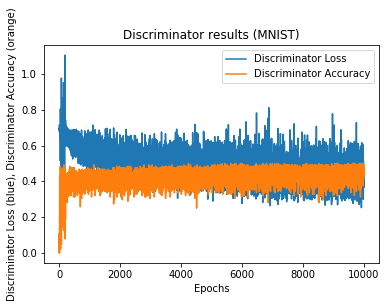

In [21]:
plt.plot(D_L)
plt.title('Discriminator results (MNIST)')
plt.xlabel('Epochs')
plt.ylabel('Discriminator Loss (blue), Discriminator Accuracy (orange)')
plt.legend(['Discriminator Loss', 'Discriminator Accuracy'])
plt.show()

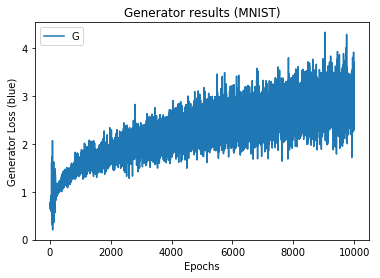

In [22]:
plt.plot(G_L)
plt.title('Generator results (MNIST)')
plt.xlabel('Epochs')
plt.ylabel('Generator Loss (blue)')
plt.legend('Generator Loss')
plt.show()